<a href="https://colab.research.google.com/github/claudio1975/Generative_Modelling/blob/main/CTVAE/Synthetic_Data_with_CTVAE_D1_D2_80_GENDER_MASKED_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Workspace

In [1]:
! pip install shap &> /dev/null

In [2]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model,Input
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, make_scorer
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import umap
from sklearn.linear_model import TweedieRegressor
import shap
from sklearn.mixture import GaussianMixture
from joblib import dump
from joblib import load

import warnings
warnings.filterwarnings('ignore')

In [3]:
DEFAULT_RANDOM_SEED = 0 # Set a random seed for reproducibility throughout Python, NumPy, and TensorFlow operations
random.seed(DEFAULT_RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(DEFAULT_RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(DEFAULT_RANDOM_SEED)
tf.random.set_seed(DEFAULT_RANDOM_SEED)

In [4]:
pip list

Package                                  Version
---------------------------------------- --------------------
absl-py                                  1.4.0
accelerate                               1.12.0
access                                   1.1.9
affine                                   2.4.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.2
aiosignal                                1.4.0
aiosqlite                                0.21.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.2
altair                                   5.5.0
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.11.0
anywidget                          

### Functions

In [5]:
# Setting Random Seeds
np.random.seed(0)
tf.random.set_seed(0)

class TransformerBlock(layers.Layer):
        def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
            super().__init__()
            #self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
            self.att = layers.MultiHeadAttention(
                num_heads=num_heads,key_dim=max(1, embed_dim // num_heads),output_shape=embed_dim)
            self.ffn = tf.keras.Sequential([
                layers.Dense(ff_dim, activation='relu'),
                layers.Dense(embed_dim),
            ])
            self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
            self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
            self.dropout1 = layers.Dropout(rate)
            self.dropout2 = layers.Dropout(rate)

        def call(self, inputs, training=False):
            attn_output = self.att(inputs, inputs)
            attn_output = self.dropout1(attn_output, training=training)
            out1 = self.layernorm1(inputs + attn_output)
            ffn_output = self.ffn(out1)
            ffn_output = self.dropout2(ffn_output, training=training)
            return self.layernorm2(out1 + ffn_output)


def train_cvae_model(
    X_train,
    condition_col,
    target_discrete,
    target_continuous,
    hidden_dim,
    latent_dim,
    embed_dim,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    epochs,
    batch_size,
    penalty_weight_nb,
    penalty_weight_amt):

    """
    Train a Conditional VAE with a Transformer-based decoder on X_train.
    Returns: (cvae_model, feature, means, stds_corrected)
    """
    # ------------------------------
    # Feature selection & normalize
    # ------------------------------
    features = [col for col in X_train.columns if col != condition_col]
    X_features = X_train[features].values.astype('float32')
    X_condition = X_train[condition_col].values.reshape(-1, 1).astype('float32')

    means = np.mean(X_features, axis=0)
    stds = np.std(X_features, axis=0)
    stds_corrected = np.where(stds == 0, 1.0, stds).astype('float32')
    X_features_norm = (X_features - means) / stds_corrected

    X_input = np.concatenate([X_features_norm, X_condition], axis=1).astype('float32')

    # ------------------------------
    # Model dimensions
    # ------------------------------
    input_dim = X_input.shape[1]
    condition_dim = 1  # binary ClaimOcc

    # ------------------------------
    # Encoder
    # ------------------------------
    encoder_inputs = layers.Input(shape=(input_dim,), name='encoder_input')
    x_enc = layers.Dense(hidden_dim, activation='relu')(encoder_inputs)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x_enc)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x_enc)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])

    # ------------------------------
    # Decoder (Transformer-based)
    # ------------------------------
    decoder_inputs = layers.Input(shape=(latent_dim + condition_dim,), name='decoder_input')

    # Project to two-token sequence [z_token, cond_token], each of size embed_dim//2
    embed_dim_per_token = max(2, embed_dim // 2)
    seq = layers.Dense(2 * embed_dim_per_token, activation='relu')(decoder_inputs)
    seq = layers.Reshape((2, embed_dim_per_token))(seq)

    for _ in range(num_transformer_blocks):
        seq = TransformerBlock(embed_dim=embed_dim_per_token, num_heads=num_heads, ff_dim=ff_dim)(seq)

    seq = layers.Flatten()(seq)
    x_dec = layers.Dense(hidden_dim, activation='relu')(seq)
    decoder_outputs = layers.Dense(input_dim - condition_dim, activation='linear', name='recon_features')(x_dec)

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    decoder = Model(decoder_inputs, decoder_outputs, name='decoder')

    # ---- Loss (normalized space for all reconstructed features)
    def vae_loss(x, x_decoded, z_mean, z_log_var, condition):
        x_features = x[:, :-condition_dim]
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(x_features - x_decoded), axis=1)
        )
        claim_amount_idx = features.index(target_continuous)
        claim_nb_idx = features.index(target_discrete)
        x_decoded_claim_amount = x_decoded[:, claim_amount_idx:claim_amount_idx + 1]
        x_decoded_claim_nb = x_decoded[:, claim_nb_idx:claim_nb_idx + 1]
        penalty_claim_nb = tf.reduce_mean(tf.square(x_decoded_claim_nb * (1 - condition)))
        penalty_claim_amount = tf.reduce_mean(tf.square(x_decoded_claim_amount * (1 - condition)))
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        return (reconstruction_loss
                + penalty_weight_nb * penalty_claim_nb
                + penalty_weight_amt * penalty_claim_amount
                + kl_loss)

    class CVAE(Model):
        def __init__(self, encoder, decoder, **kwargs):
            super().__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        def train_step(self, data):
            x = data
            with tf.GradientTape() as tape:
                z_mean, z_log_var, z = self.encoder(x, training=True)
                condition = x[:, -condition_dim:]
                dec_input = tf.concat([z, condition], axis=1)
                x_decoded = self.decoder(dec_input, training=True)
                loss = vae_loss(x, x_decoded, z_mean, z_log_var, condition)
            grads = tape.gradient(loss, self.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
            return {"loss": loss}

        def call(self, inputs):
            z_mean, z_log_var, z = self.encoder(inputs, training=False)
            condition = inputs[:, -condition_dim:]
            dec_input = tf.concat([z, condition], axis=1)
            return self.decoder(dec_input, training=False)

    # ---- Compile & train
    cvae = CVAE(encoder, decoder)
    cvae.compile(optimizer='adam')
    print(f"Training CVAE on input shape: {X_input.shape}")
    cvae.fit(X_input, epochs=epochs, batch_size=batch_size, verbose=1)

    # Attach for convenience
    cvae.means = means
    cvae.stds_corrected = stds_corrected
    cvae.features = features
    cvae.condition_col = condition_col

    # *** return scaling to reuse it at sampling time ***
    return cvae, encoder, decoder, X_input, means, stds_corrected, features



In [6]:
def generate_cvae_synthetic_data(cvae_model,
                                 num_samples,
                                 claim_occ_values,
                                 feature_names,
                                 means,
                                 stds_corrected,
                                 X_train,
                                 condition_col,
                                 target_discrete,
                                 target_continuous,
                                 latent_dim,
                                 condition_dim,
                                 columns_to_round=None):
    """
    Generates synthetic data using a trained CVAE model.

    Parameters:
    - cvae_model: Trained a Conditional VAE with a Transformer-based decoder
    - num_samples: Total number of synthetic samples to generate
    - claim_occ_values: List or tuple of values for the condition column (e.g., [0, 1])
    - feature_names: Names of the reconstructed features used during training (EXCLUDES condition)
    - means: Per-feature means used for normalization during training (for decoder outputs only)
    - stds_corrected: Per-feature stds with zeros replaced by 1, from training (Solution A)
    - X_train: Original training data (used to learn proportions for condition)
    - condition_col: Name of the condition column (default: 'ClaimOcc')
    - target_discrete: Name of discrete target column (default: 'ClaimNb')
    - target_continuous: Name of continuous target column (default: 'ClaimAmount')
    - latent_dim: Latent space dimensionality (must match training)
    - condition_dim: Dimensionality of condition vector (usually 1)
    - columns_to_round: List of other columns to round to int

    Returns:
    - synthetic_data (pd.DataFrame): Combined and shuffled synthetic dataset
    """

    # Just to safe avoiding division by zero
    stds_corrected = np.where(stds_corrected == 0.0, 1.0, stds_corrected).astype('float32')
    means = means.astype('float32')

    def generate_subset(n, claim_occ_value):
        if n <= 0:
            return pd.DataFrame()

        # Sample latent and build decoder input [z || condition]
        latent_samples = np.random.normal(size=(n, latent_dim)).astype('float32')
        condition = np.full((n, condition_dim), claim_occ_value, dtype='float32')
        decoder_input = np.concatenate([latent_samples, condition], axis=1)

        # Predict normalized features, then inverse-transform with exact training scaling
        normalized_samples = cvae_model.decoder.predict(decoder_input, verbose=0)
        samples = normalized_samples * stds_corrected + means

        # To DataFrame with same order as training features (excluding condition)
        df = pd.DataFrame(samples, columns=feature_names)
        df[condition_col] = claim_occ_value

        # Fix ClaimNb (discrete)
        if target_discrete in feature_names:
            claim_nb_idx = feature_names.index(target_discrete)
            df.iloc[:, claim_nb_idx] = np.round(df.iloc[:, claim_nb_idx]).astype(int)
        else:
            raise ValueError(f"{target_discrete} not found in feature_names")

        # Fix ClaimAmount based on ClaimNb and condition
        if target_continuous in feature_names:
            claim_amount_idx = feature_names.index(target_continuous)
            claim_nb_values = df.iloc[:, claim_nb_idx].values

            # If no claim occurred by condition, zero out
            df.loc[df[condition_col] == 0, target_discrete] = 0
            df.loc[df[condition_col] == 0, target_continuous] = 0.0

            # If count is zero, amount must be zero
            df.loc[df[target_discrete] == 0, target_continuous] = 0.0

            # For positive counts, ensure non-negative amount
            pos_mask = df[target_discrete] > 0
            if pos_mask.any():
                df.loc[pos_mask, target_continuous] = np.clip(
                    df.loc[pos_mask, target_continuous].to_numpy(), a_min=0.0, a_max=None
                )

        else:
            raise ValueError(f"{target_continuous} not found in feature_names")

        # ensure realistic values of exposure
        if 'Exposure' in df.columns:
          df['Exposure'] = df['Exposure'].clip(0, 1)

        # Round additional specified columns
        if columns_to_round:
            for col in columns_to_round:
                if col in df.columns and col != target_discrete:
                    df[col] = df[col].round().astype(int)


        # Replace any remaining negative values. Just to safe
        df = df.clip(lower=0)

        return df

    # Edge: zero samples requested
    if num_samples == 0:
        return pd.DataFrame(columns=list(feature_names) + [condition_col])

    # Proportions by condition from training
    proportions = X_train[condition_col].value_counts(normalize=True)
    # Determine counts per condition value requested
    counts = (proportions * num_samples).round().astype(int)

    # Adjust to exactly match num_samples
    diff = num_samples - counts.sum()
    if diff != 0 and len(counts) > 0:
        counts[counts.idxmax()] += diff

    # Generate subsets for the claim_occ_values present in training
    data_frames = []
    for val, n in counts.items():
        if val in claim_occ_values:
            data_frames.append(generate_subset(n, val))

    # Combine and shuffle
    if len(data_frames) == 0:
        # If none matched (e.g., claim_occ_values excludes all training values), return empty with columns
        return pd.DataFrame(columns=list(feature_names) + [condition_col])

    synthetic_data = pd.concat(data_frames, ignore_index=True)
    synthetic_data = synthetic_data.sample(frac=1, random_state=0).reset_index(drop=True)

    return synthetic_data


In [7]:
def compare_real_vs_synthetic(real_df, synthetic_df, columns=None, kind='hist', bins=30, figsize=(15, 10)):
    """
    Compare distributions between real and synthetic datasets.

    Parameters:
    - real_df: pd.DataFrame, the original dataset
    - synthetic_df: pd.DataFrame, the synthetic dataset
    - columns: list of column names to compare; if None, all columns are used
    - kind: str, type of plot: 'hist', 'kde', or 'box'
    - bins: int, number of bins for histograms
    - figsize: tuple, size of the plot figure

    Returns:
    - None (displays plots)
    """
    if columns is None:
        columns = [col for col in real_df.columns if real_df[col].dtype != 'object']

    n_cols = 2
    n_rows = (len(columns) + 1) // n_cols

    plt.figure(figsize=figsize)

    for idx, col in enumerate(columns, 1):
        plt.subplot(n_rows, n_cols, idx)

        if kind == 'hist':
            sns.histplot(real_df[col], color='blue', label='Real', kde=False, stat='density', bins=bins, alpha=0.6)
            sns.histplot(synthetic_df[col], color='red', label='Synthetic', kde=False, stat='density', bins=bins, alpha=0.6)

        elif kind == 'kde':
            sns.kdeplot(real_df[col], color='blue', label='Real')
            sns.kdeplot(synthetic_df[col], color='red', label='Synthetic')

        elif kind == 'box':
            sns.boxplot(data=[real_df[col], synthetic_df[col]], palette=['blue', 'red'])
            plt.xticks([0, 1], ['Real', 'Synthetic'])

        else:
            raise ValueError("Unsupported plot kind. Choose from 'hist', 'kde', or 'box'.")

        plt.title(f"Comparison for '{col}'")
        plt.legend()

    plt.tight_layout()
    plt.show()


In [8]:
def pca_visual_comparison_3d(real_df, synthetic_df, color_by=None, title_suffix="", var=None):
    """
    Compare real vs synthetic datasets using 3D PCA projection.

    Parameters:
    - real_df: pd.DataFrame, the original dataset
    - synthetic_df: pd.DataFrame, the synthetic dataset
    - color_by: str, optional column name for coloring points (must exist in both datasets)
    - title_suffix: str, suffix to append to plot title

    Returns:
    - None (displays PCA 3D scatter plot)
    """
    assert set(real_df.columns) == set(synthetic_df.columns), "Datasets must have the same columns."

    # Combine for joint scaling
    combined_df = pd.concat([real_df, synthetic_df])
    features = combined_df.drop(columns=[color_by]) if color_by else combined_df
    scaler = StandardScaler()
    combined_scaled = scaler.fit_transform(features)

    # Fit PCA (3 components for 3D)
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(combined_scaled)
    dump(pca, f'pca_model_{var}_ctvae_gender.pkl')
    dump(scaler, f'scaler_pca_model_{var}_ctvae_gender.pkl')

    # Separate PCA results
    n_real = len(real_df)
    real_pca = pca_result[:n_real]
    synth_pca = pca_result[n_real:]

    # Prepare figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot real data
    ax.scatter(real_pca[:, 0], real_pca[:, 1], real_pca[:, 2],
               c='blue', label='Real', s=40, alpha=0.6, edgecolor='k')

    # Plot synthetic data
    ax.scatter(synth_pca[:, 0], synth_pca[:, 1], synth_pca[:, 2],
               c='red', label='Synthetic', s=40, alpha=0.6, edgecolor='k')

    ax.set_title(f"3D PCA: Real vs. Synthetic {title_suffix}", fontsize=12, weight='bold')
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    ax.grid(False)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [9]:
def umap_visual_comparison_3d(real_df, synthetic_df, n_neighbors=15, min_dist=0.1, metric='euclidean', color_by=None, title_suffix="", var=None):
    """
    Compare real vs synthetic datasets using 3D UMAP projection.

    Parameters:
    - real_df: pd.DataFrame, the original dataset
    - synthetic_df: pd.DataFrame, the synthetic dataset
    - color_by: str, optional column name for color grouping
    - title_suffix: str, optional title suffix

    Returns:
    - None
    """
    assert set(real_df.columns) == set(synthetic_df.columns), "Datasets must have the same columns."

    # Combine datasets for scaling
    combined_df = pd.concat([real_df, synthetic_df])
    if color_by and color_by in combined_df.columns:
        features = combined_df.drop(columns=[color_by])
    else:
        features = combined_df

    # Normalize features
    scaler = StandardScaler()
    combined_scaled = scaler.fit_transform(features)

    # UMAP transformation
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=3,
        metric=metric,
        random_state=42
    )
    umap_result = reducer.fit_transform(combined_scaled)
    dump(reducer, f'umap_model_{var}_ctvae_gender.pkl')
    dump(scaler, f'scaler_umap_model_{var}_ctvae_gender.pkl')


    # Separate results
    n_real = len(real_df)
    real_umap = umap_result[:n_real]
    synth_umap = umap_result[n_real:]

    # Plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot real and synthetic points and store the artists
    real_plot = ax.scatter(real_umap[:, 0], real_umap[:, 1], real_umap[:, 2],
                           c='blue', s=40, alpha=0.6, edgecolor='k', label='Real')

    synth_plot = ax.scatter(synth_umap[:, 0], synth_umap[:, 1], synth_umap[:, 2],
                            c='red', s=40, alpha=0.6, edgecolor='k', label='Synthetic')

    # Titles and labels
    ax.set_title(f"3D UMAP: Real vs. Synthetic {title_suffix}", fontsize=12, weight='bold')
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_zlabel("UMAP3")

    # Manual legend
    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()


In [10]:
def run_glm_frequency_analysis(
    X_train, X_test, model=None, clip_exposure=False, random_state=0, label="Model"
):
    """
    Run GLM Poisson regression frequency analysis (ClaimNb ~ Features | Exposure).

    Parameters:
    - X_train: pd.DataFrame with ['Exposure', 'ClaimNb', ...]
    - X_test: pd.DataFrame with ['Exposure', 'ClaimNb', ...]
    - model: sklearn regressor, default is TweedieRegressor(power=1, link='log')
    - clip_exposure: bool, if True, caps Exposure at 1 in training set
    - random_state: int, for reproducibility
    - label: str, label for printing/logging

    Returns:
    - trained_model: fitted model
    - results: dict with CV scores, deviance on train/test, and predictions
    """

    np.random.seed(0)

    # Optionally clip exposure in training data
    if clip_exposure:
        X_train = X_train.copy()
        X_train['Exposure'] = np.where(X_train['Exposure'] > 1, 1, X_train['Exposure'])

    # Filter for Exposure > 0
    mask_tr = X_train['Exposure'] > 0
    mask_te = X_test['Exposure'] > 0
    X_train_f = X_train[mask_tr].copy()
    X_test_f = X_test[mask_te].copy()

    y_train = X_train_f['ClaimNb']
    y_test = X_test_f['ClaimNb']
    exposure_train = X_train_f['Exposure']
    exposure_test = X_test_f['Exposure']

    X_train_ = X_train_f.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
    X_test_ = X_test_f.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

    # Set model if not passed
    if model is None:
        model = TweedieRegressor(power=1, link='log')

    # Cross-validation
    cv = KFold(n_splits=5)
    mpd_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_)):
        X_tr, X_val = X_train_.iloc[train_idx], X_train_.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        w_tr, w_val = exposure_train.iloc[train_idx], exposure_train.iloc[val_idx]

        model.fit(X_tr, y_tr / w_tr, sample_weight=w_tr)
        y_pred = model.predict(X_val)

        score = mean_poisson_deviance(y_val / w_val, y_pred)
        print(f"Fold {fold_idx + 1} Poisson Deviance Score: {score:.4f}")
        mpd_scores.append(score)

    print(f"Average cross-validation Poisson Deviance Score: {np.mean(mpd_scores):.4f}")
    print(f"Standard Deviation of CV Scores: {np.std(mpd_scores):.4f}")

    # Final fit on full training set
    model.fit(X_train_, y_train / exposure_train, sample_weight=exposure_train)

    pred_train = model.predict(X_train_)
    pred_test = model.predict(X_test_)

    mpd_train = mean_poisson_deviance(y_train / exposure_train, pred_train)
    mpd_test = mean_poisson_deviance(y_test / exposure_test, pred_test)

    print(f"Train Poisson Deviance: {mpd_train:.4f}")
    print(f"Test Poisson Deviance: {mpd_test:.4f}")

    return model, {
        "cv_scores": mpd_scores,
        "mpd_train": mpd_train,
        "mpd_test": mpd_test,
        "train_predictions": pred_train,
        "test_predictions": pred_test
    }


In [11]:
def run_glm_cost_analysis(X_train, X_test, is_sampled=False, verbose=True):
    """
    Perform GLM Cost Analysis using Tweedie Regressor (power=2, link='log').

    Parameters:
    - X_train: Training DataFrame (must include 'ClaimAmount', 'ClaimNb', 'Exposure')
    - X_test: Testing DataFrame
    - is_sampled: If True, cap 'Exposure' at 1 for training data
    - verbose: If True, print CV results and scores

    Returns:
    - Dictionary containing train/test gamma deviance and predictions
    """
    np.random.seed(0)

    # Cap exposure if sampled
    if is_sampled:
        X_train = X_train.copy()
        X_train['Exposure'] = np.where(X_train['Exposure'] > 1, 1, X_train['Exposure'])

    X_train_co = X_train.copy()
    X_test_co = X_test.copy()

    # Compute average cost per claim (Acost)
    X_train_co['Acost'] = np.where(X_train_co['ClaimNb'] != 0,
                                   X_train_co['ClaimAmount'] / X_train_co['ClaimNb'], 0)
    X_test_co['Acost'] = np.where(X_test_co['ClaimNb'] != 0,
                                  X_test_co['ClaimAmount'] / X_test_co['ClaimNb'], 0)

    # Filter rows with non-zero claim amounts
    X_train_cost = X_train_co[X_train_co['ClaimAmount'] != 0].copy()
    X_test_cost = X_test_co[X_test_co['ClaimAmount'] != 0].copy()

    # Target and weights
    y_train = X_train_cost['Acost']
    claim_tr = X_train_cost['ClaimNb']
    y_test = X_test_cost['Acost']
    claim_te = X_test_cost['ClaimNb']

    # Features
    drop_cols = ['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb']
    X_train_ = X_train_cost.drop(columns=drop_cols)
    X_test_ = X_test_cost.drop(columns=drop_cols)

    # Initialize model
    glm_cl = TweedieRegressor(power=2, link='log')

    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    mgd_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_)):
        X_tr, X_val = X_train_.iloc[train_idx], X_train_.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        w_tr, w_val = claim_tr.iloc[train_idx], claim_tr.iloc[val_idx]

        glm_cl.fit(X_tr, y_tr, sample_weight=w_tr)
        y_pred_val = glm_cl.predict(X_val)
        score = mean_gamma_deviance(y_val, y_pred_val)
        mgd_scores.append(score)

        if verbose:
            print(f"Fold {fold_idx + 1} Gamma Deviance Score: {score:.4f}")

    if verbose:
        print("Average cross-validation Gamma Deviance Score:", np.mean(mgd_scores))
        print("Standard Deviation of CV Scores:", np.std(mgd_scores))

    # Train on full data
    glm_cl.fit(X_train_, y_train, sample_weight=claim_tr)

    # Predictions
    y_pred_train = glm_cl.predict(X_train_)
    y_pred_test = glm_cl.predict(X_test_)

    # Deviance on train and test
    mgd_train = mean_gamma_deviance(y_train, y_pred_train)
    mgd_test = mean_gamma_deviance(y_test, y_pred_test)

    if verbose:
        print(f"Train Gamma Deviance: {mgd_train:.4f}")
        print(f"Test Gamma Deviance: {mgd_test:.4f}")

    return {
        "cv_scores": mgd_scores,
        'mgd_train': mgd_train,
        'mgd_test': mgd_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test
    }


In [12]:
def plot_glm_shap_importance(
    X_train, X_test, y_train, sample_weight,
    power: int, title: str, max_display: int = 10, figsize: tuple = (5, 5), seed: int = 0
):
    """
    Compute and plot SHAP feature importance for GLMs using SHAP LinearExplainer.

    Parameters:
        X_train (pd.DataFrame): Training features
        X_test (pd.DataFrame): Test features
        y_train (pd.Series or np.array): Training target
        sample_weight (pd.Series or np.array): Sample weights
        power (int): Tweedie power (1 = Poisson for frequency, 2 = Gamma for severity)
        title (str): Title for the plot
        max_display (int): Max number of features to display
        figsize (tuple): Size of the figure
        seed (int): Random seed for reproducibility
    """
    np.random.seed(seed)

    model = TweedieRegressor(power=power, link='log')
    model.fit(X_train, y_train, sample_weight=sample_weight)

    masker = shap.maskers.Independent(X_train)
    explainer = shap.LinearExplainer(model, masker=masker)
    shap_values = explainer.shap_values(X_test)

    plt.rcParams['figure.figsize'] = figsize
    shap.summary_plot(
        shap_values, features=X_test,
        feature_names=X_test.columns,
        plot_type='bar',
        max_display=max_display,
        show=False
    )
    plt.title(title, fontsize=12)
    plt.tight_layout()
    plt.show()


### Upload dataset and data handling

In [13]:
#-------------------
# D1
#-------------------
df1=pd.read_csv('/content/ausprivauto0405.csv')

In [14]:
print(df1.shape)

(67856, 9)


In [15]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67856 entries, 0 to 67855
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Exposure     67856 non-null  float64
 1   VehValue     67856 non-null  float64
 2   VehAge       67856 non-null  object 
 3   VehBody      67856 non-null  object 
 4   Gender       67856 non-null  object 
 5   DrivAge      67856 non-null  object 
 6   ClaimOcc     67856 non-null  int64  
 7   ClaimNb      67856 non-null  int64  
 8   ClaimAmount  67856 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 4.7+ MB
None


In [16]:
print(df1.columns)

Index(['Exposure', 'VehValue', 'VehAge', 'VehBody', 'Gender', 'DrivAge',
       'ClaimOcc', 'ClaimNb', 'ClaimAmount'],
      dtype='object')


In [17]:
df1.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
0,0.303901,1.06,old cars,Hatchback,Female,young people,0,0,0.0
1,0.648871,1.03,young cars,Hatchback,Female,older work. people,0,0,0.0
2,0.569473,3.26,young cars,Utility,Female,young people,0,0,0.0
3,0.317591,4.14,young cars,Station wagon,Female,young people,0,0,0.0
4,0.648871,0.72,oldest cars,Hatchback,Female,young people,0,0,0.0


In [18]:
df1_duplicated_rows=df1[df1.duplicated()]
df1_duplicated_rows

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
63,0.095825,2.650,youngest cars,Sedan,Female,working people,0,0,0.0
152,0.616016,0.450,oldest cars,Hatchback,Female,oldest people,0,0,0.0
1003,0.002738,3.170,youngest cars,Utility,Male,youngest people,0,0,0.0
1031,0.848734,4.700,youngest cars,Station wagon,Female,young people,0,0,0.0
1165,0.903491,1.280,oldest cars,Station wagon,Male,oldest people,0,0,0.0
...,...,...,...,...,...,...,...,...,...
67769,0.251882,0.980,old cars,Sedan,Female,old people,0,0,0.0
67779,0.851472,5.236,youngest cars,Station wagon,Female,older work. people,0,0,0.0
67796,0.908966,2.440,youngest cars,Sedan,Female,old people,0,0,0.0
67811,0.769336,1.200,old cars,Sedan,Male,youngest people,0,0,0.0


In [19]:
df1=df1.drop_duplicates()

In [20]:
df1_duplicated_col=df1.columns[df1.columns.duplicated()]
df1_duplicated_col

Index([], dtype='object')

In [21]:
missing=df1.isnull().sum()/df1.shape[0]*100
missing

,0
Exposure,0.0
VehValue,0.0
VehAge,0.0
VehBody,0.0
Gender,0.0
DrivAge,0.0
ClaimOcc,0.0
ClaimNb,0.0
ClaimAmount,0.0


### Encoding

In [22]:
print(df1['VehAge'].unique())
print(df1['DrivAge'].unique())
print(df1['VehBody'].unique())
print(df1['Gender'].unique())


['old cars' 'young cars' 'oldest cars' 'youngest cars']
['young people' 'older work. people' 'oldest people' 'working people'
 'old people' 'youngest people']
['Hatchback' 'Utility' 'Station wagon' 'Hardtop' 'Panel van' 'Sedan'
 'Truck' 'Coupe' 'Minibus' 'Motorized caravan' 'Bus' 'Convertible'
 'Roadster']
['Female' 'Male']


In [23]:
df1_encod=df1.copy()
df1_encod=df1_encod.drop(columns=['Gender'])
# VehAge
VehAge_group = {'old cars':'1','young cars':'2','oldest cars':'3','youngest cars':'4'}
df1_encod['VehAge'] = df1_encod['VehAge'].map(VehAge_group)
df1_encod['VehAge']= df1_encod['VehAge'].astype(int)
# DrivAge
DrivAge_group = {'young people':'1','older work. people':'2','oldest people':'3','working people':'4','old people':'5','youngest people':'6'}
df1_encod['DrivAge'] = df1_encod['DrivAge'].map(DrivAge_group)
df1_encod['DrivAge']= df1_encod['DrivAge'].astype(int)
# VehBody
VehBody_group = {'Hatchback':'1','Utility':'2','Station wagon':'3','Hardtop':'4','Panel van':'5','Sedan':'6','Truck':'7',\
                'Coupe':'8', 'Minibus':'9', 'Motorized caravan':'10', 'Bus':'11', 'Convertible':'12','Roadster':'13'}
df1_encod['VehBody'] = df1_encod['VehBody'].map(VehBody_group)
df1_encod['VehBody']= df1_encod['VehBody'].astype(int)
# Gender
#Gender_group = {'Female':'0','Male':'1'}
#df1_encod['Gender'] = df1_encod['Gender'].map(Gender_group)
#df1_encod['Gender']= df1_encod['Gender'].astype(int)




In [24]:
df1_encod.head()

,Exposure,VehValue,VehAge,VehBody,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
0,0.303901,1.06,1,1,1,0,0,0.0
1,0.648871,1.03,2,1,2,0,0,0.0
2,0.569473,3.26,2,2,1,0,0,0.0
3,0.317591,4.14,2,3,1,0,0,0.0
4,0.648871,0.72,3,1,1,0,0,0.0


### Split dataset

In [25]:
# Split the dataset into train/test split
X_train, X_test = train_test_split(df1_encod, test_size=0.2, random_state=0)

In [26]:
X_train.shape

(53320, 8)

### Build a CTVAE

In [27]:
cvae_d1, encoder_d1, decoder_d1, X_input_d1, means_d1, stds_corrected_d1, features_d1 =train_cvae_model(
    X_train=X_train,
    condition_col='ClaimOcc',
    target_discrete='ClaimNb',
    target_continuous='ClaimAmount',
    hidden_dim=64,
    latent_dim=5,
    embed_dim=64,
    num_heads=4,
    ff_dim=64,
    num_transformer_blocks=3,
    epochs=30,
    batch_size=128,
    penalty_weight_nb=1.0,
    penalty_weight_amt=1.0)

Training CVAE on input shape: (53320, 8)
Epoch 1/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 6.5385
Epoch 2/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 4.6820
Epoch 3/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 4.4602
Epoch 4/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 4.4033
Epoch 5/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 4.3928
Epoch 6/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 4.3504
Epoch 7/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 4.3372
Epoch 8/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 4.3271
Epoch 9/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 4.3086
Epoch 10/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 4.3138
Epoch 11/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 4.3007
Epoch 12/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 4.2698
Epoch 13/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 4.2692
Epoch 14/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 4.2548

### Generate Samples

In [28]:
synthetic_data = generate_cvae_synthetic_data(
    cvae_model=cvae_d1,
    num_samples=len(X_train),
    claim_occ_values=[0, 1],
    feature_names=features_d1,         # excludes the condition column
    means=means_d1,                    # from training
    stds_corrected=stds_corrected_d1,  # from training
    X_train=X_train,
    condition_col='ClaimOcc',
    target_discrete='ClaimNb',
    target_continuous='ClaimAmount',
    latent_dim=5,
    condition_dim=1,
    columns_to_round=['VehAge', 'DrivAge', 'VehBody']
)

### Use Generate Samples Dataframe

In [29]:
new_samples_df=synthetic_data.copy()

In [30]:
new_samples_df.to_csv('d1_ctvae_gender_encod.csv')

In [31]:
df1_decod=new_samples_df.copy()
# VehAge
VehAge_group = {1:'old cars',2:'young cars',3:'oldest cars',4:'youngest cars'}
df1_decod['VehAge'] = df1_decod['VehAge'].map(VehAge_group)
# DrivAge
DrivAge_group = {1:'young people',2:'older work. people',3:'oldest people',4:'working people',5:'old people',6:'youngest people'}
df1_decod['DrivAge'] = df1_decod['DrivAge'].map(DrivAge_group)
# VehBody
VehBody_group = {1:'Hatchback',2:'Utility',3:'Station wagon',4:'Hardtop',5:'Panel van',6:'Sedan',7:'Truck',\
                8:'Coupe', 9:'Minibus', 10:'Motorized caravan', 11:'Bus', 12:'Convertible',13:'Roadster'}
df1_decod['VehBody'] = df1_decod['VehBody'].map(VehBody_group)
# Gender
#Gender_group = {0:'Female',1:'Male'}
#df1_decod['Gender'] = df1_decod['Gender'].map(Gender_group)


In [32]:
df1_decod.to_csv('d1_ctvae_gender.csv')

### Data Comparison

In [33]:
X_train.head()

,Exposure,VehValue,VehAge,VehBody,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
16112,0.621492,1.66,1,1,5,0,0,0.0
39849,0.676249,0.70,3,3,1,0,0,0.0
41557,0.257358,2.49,1,3,3,0,0,0.0
59930,0.654346,0.86,1,2,4,0,0,0.0
60224,0.637919,2.72,2,2,1,0,0,0.0


In [34]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,53320.0,0.466535,0.288448,0.002738,0.21629,0.443532,0.706366,0.999316
VehValue,53320.0,1.784108,1.217545,0.000000,1.01000,1.500000,2.160000,34.560000
VehAge,53320.0,2.346755,1.085962,1.000000,1.00000,2.000000,3.000000,4.000000
VehBody,53320.0,3.672824,2.260395,1.000000,1.00000,3.000000,6.000000,13.000000
DrivAge,53320.0,3.193323,1.610507,1.000000,2.00000,3.000000,4.000000,6.000000
ClaimOcc,53320.0,0.069449,0.254218,0.000000,0.00000,0.000000,0.000000,1.000000
ClaimNb,53320.0,0.074194,0.280946,0.000000,0.00000,0.000000,0.000000,4.000000
ClaimAmount,53320.0,136.092076,1004.945014,0.000000,0.00000,0.000000,0.000000,46868.179932


In [35]:
new_samples_df.head()

,Exposure,VehValue,VehAge,VehBody,DrivAge,ClaimNb,ClaimAmount,ClaimOcc
0,0.334870,1.346075,1,4,2,1.0,320.907928,1
1,0.118974,3.081221,4,4,3,0.0,0.000000,0
2,0.572852,4.787681,4,3,4,0.0,0.000000,0
3,0.556658,2.003590,1,4,1,0.0,0.000000,0
4,0.667079,1.340999,2,5,2,0.0,0.000000,0


In [36]:
new_samples_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,53320.0,0.463036,0.205045,0.000000,0.287427,0.438932,0.634720,0.990591
VehValue,53320.0,1.733209,0.744777,0.450904,1.266421,1.499634,1.969527,10.351106
VehAge,53320.0,2.345424,0.863518,1.000000,2.000000,2.000000,3.000000,4.000000
VehBody,53320.0,3.581789,1.705031,0.000000,2.000000,3.000000,5.000000,13.000000
DrivAge,53320.0,3.205833,1.234244,0.000000,2.000000,3.000000,4.000000,7.000000
ClaimNb,53320.0,0.073237,0.274765,0.000000,0.000000,0.000000,0.000000,3.000000
ClaimAmount,53320.0,128.585846,767.959229,0.000000,0.000000,0.000000,0.000000,19240.087891
ClaimOcc,53320.0,0.069449,0.254218,0.000000,0.000000,0.000000,0.000000,1.000000


In [37]:
# Check for consistency
consistent_zeros = ((X_train["ClaimNb"] == 0) & (X_train["ClaimOcc"] == 0) & (X_train["ClaimAmount"] == 0)).sum()
consistent_positives = ((X_train["ClaimNb"] > 0) & (X_train["ClaimOcc"] > 0) & (X_train["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 49617
Records where all three are positive: 3703


In [38]:
# Check for consistency
consistent_zeros = ((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)).sum()
consistent_positives = ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 49617
Records where all three are positive: 3701


In [39]:
# Find inconsistencies
inconsistent_records = new_samples_df[
    ~(((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)) |
      ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)))
]

print(f"Number of inconsistent records: {len(inconsistent_records)}")
print(inconsistent_records.head())  # Show a few inconsistent rows

Number of inconsistent records: 2
       Exposure  VehValue  VehAge  VehBody  DrivAge  ClaimNb  ClaimAmount  \
14582  0.293944  1.219826       3        2        4      1.0          0.0   
41332  0.358922  3.581414       4        4        3      1.0          0.0   

       ClaimOcc  
14582         1  
41332         1  


### Visual Comparison

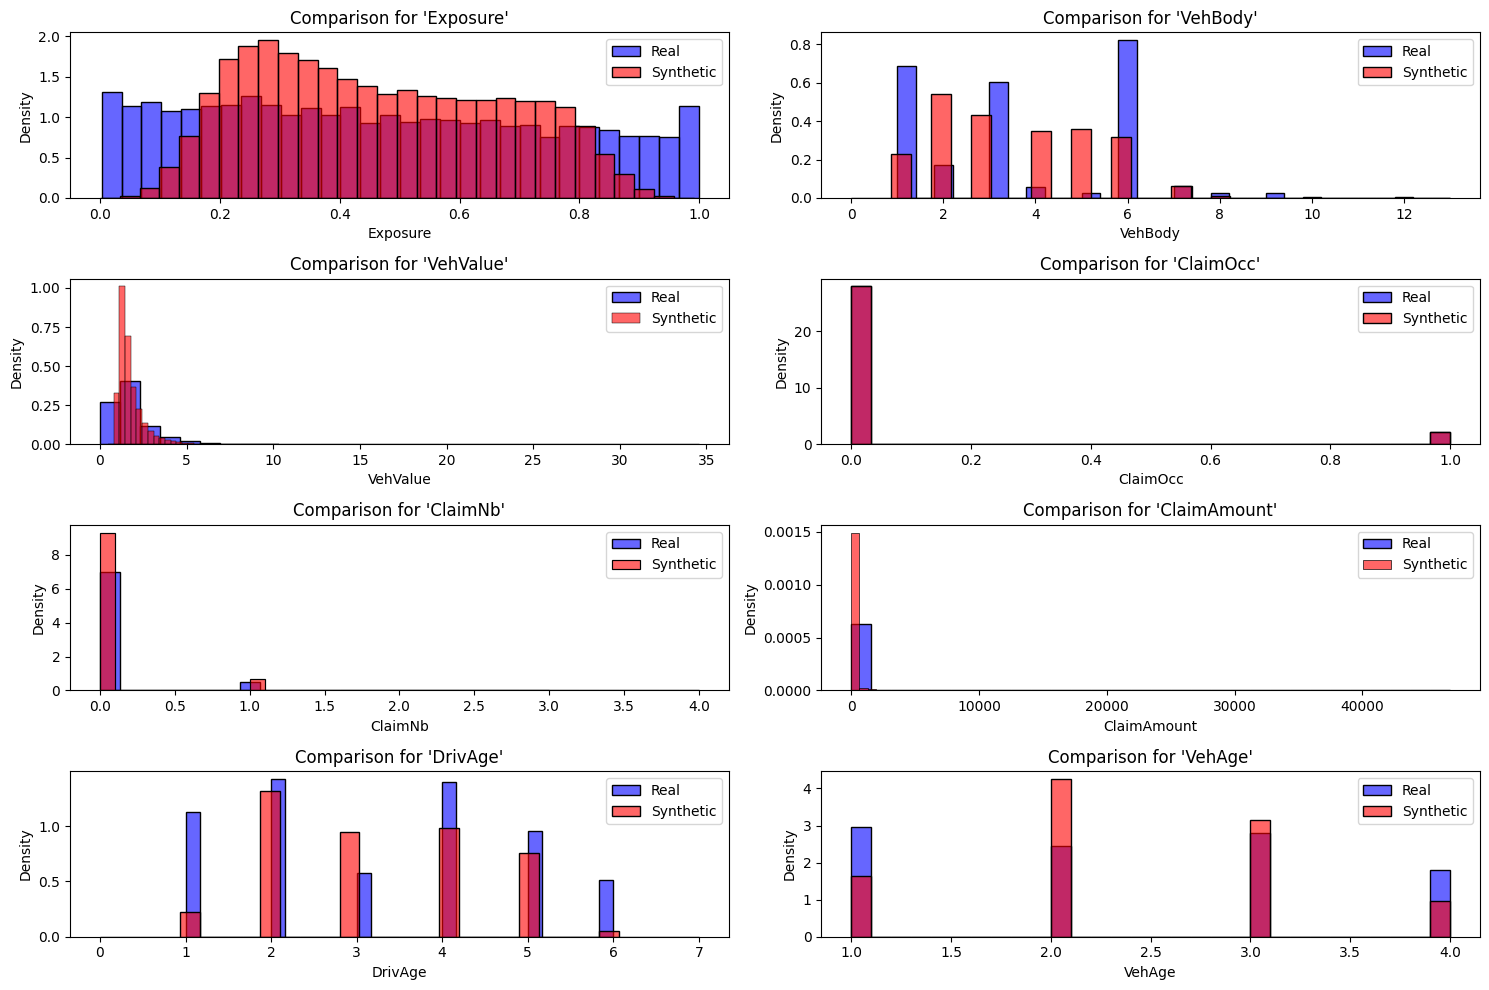

In [40]:
# Compare selected variables using histograms
compare_real_vs_synthetic(
    real_df=X_train,
    synthetic_df=synthetic_data,
    columns=['Exposure','VehBody','VehValue','ClaimOcc','ClaimNb', 'ClaimAmount', 'DrivAge', 'VehAge'],
    kind='hist'
)


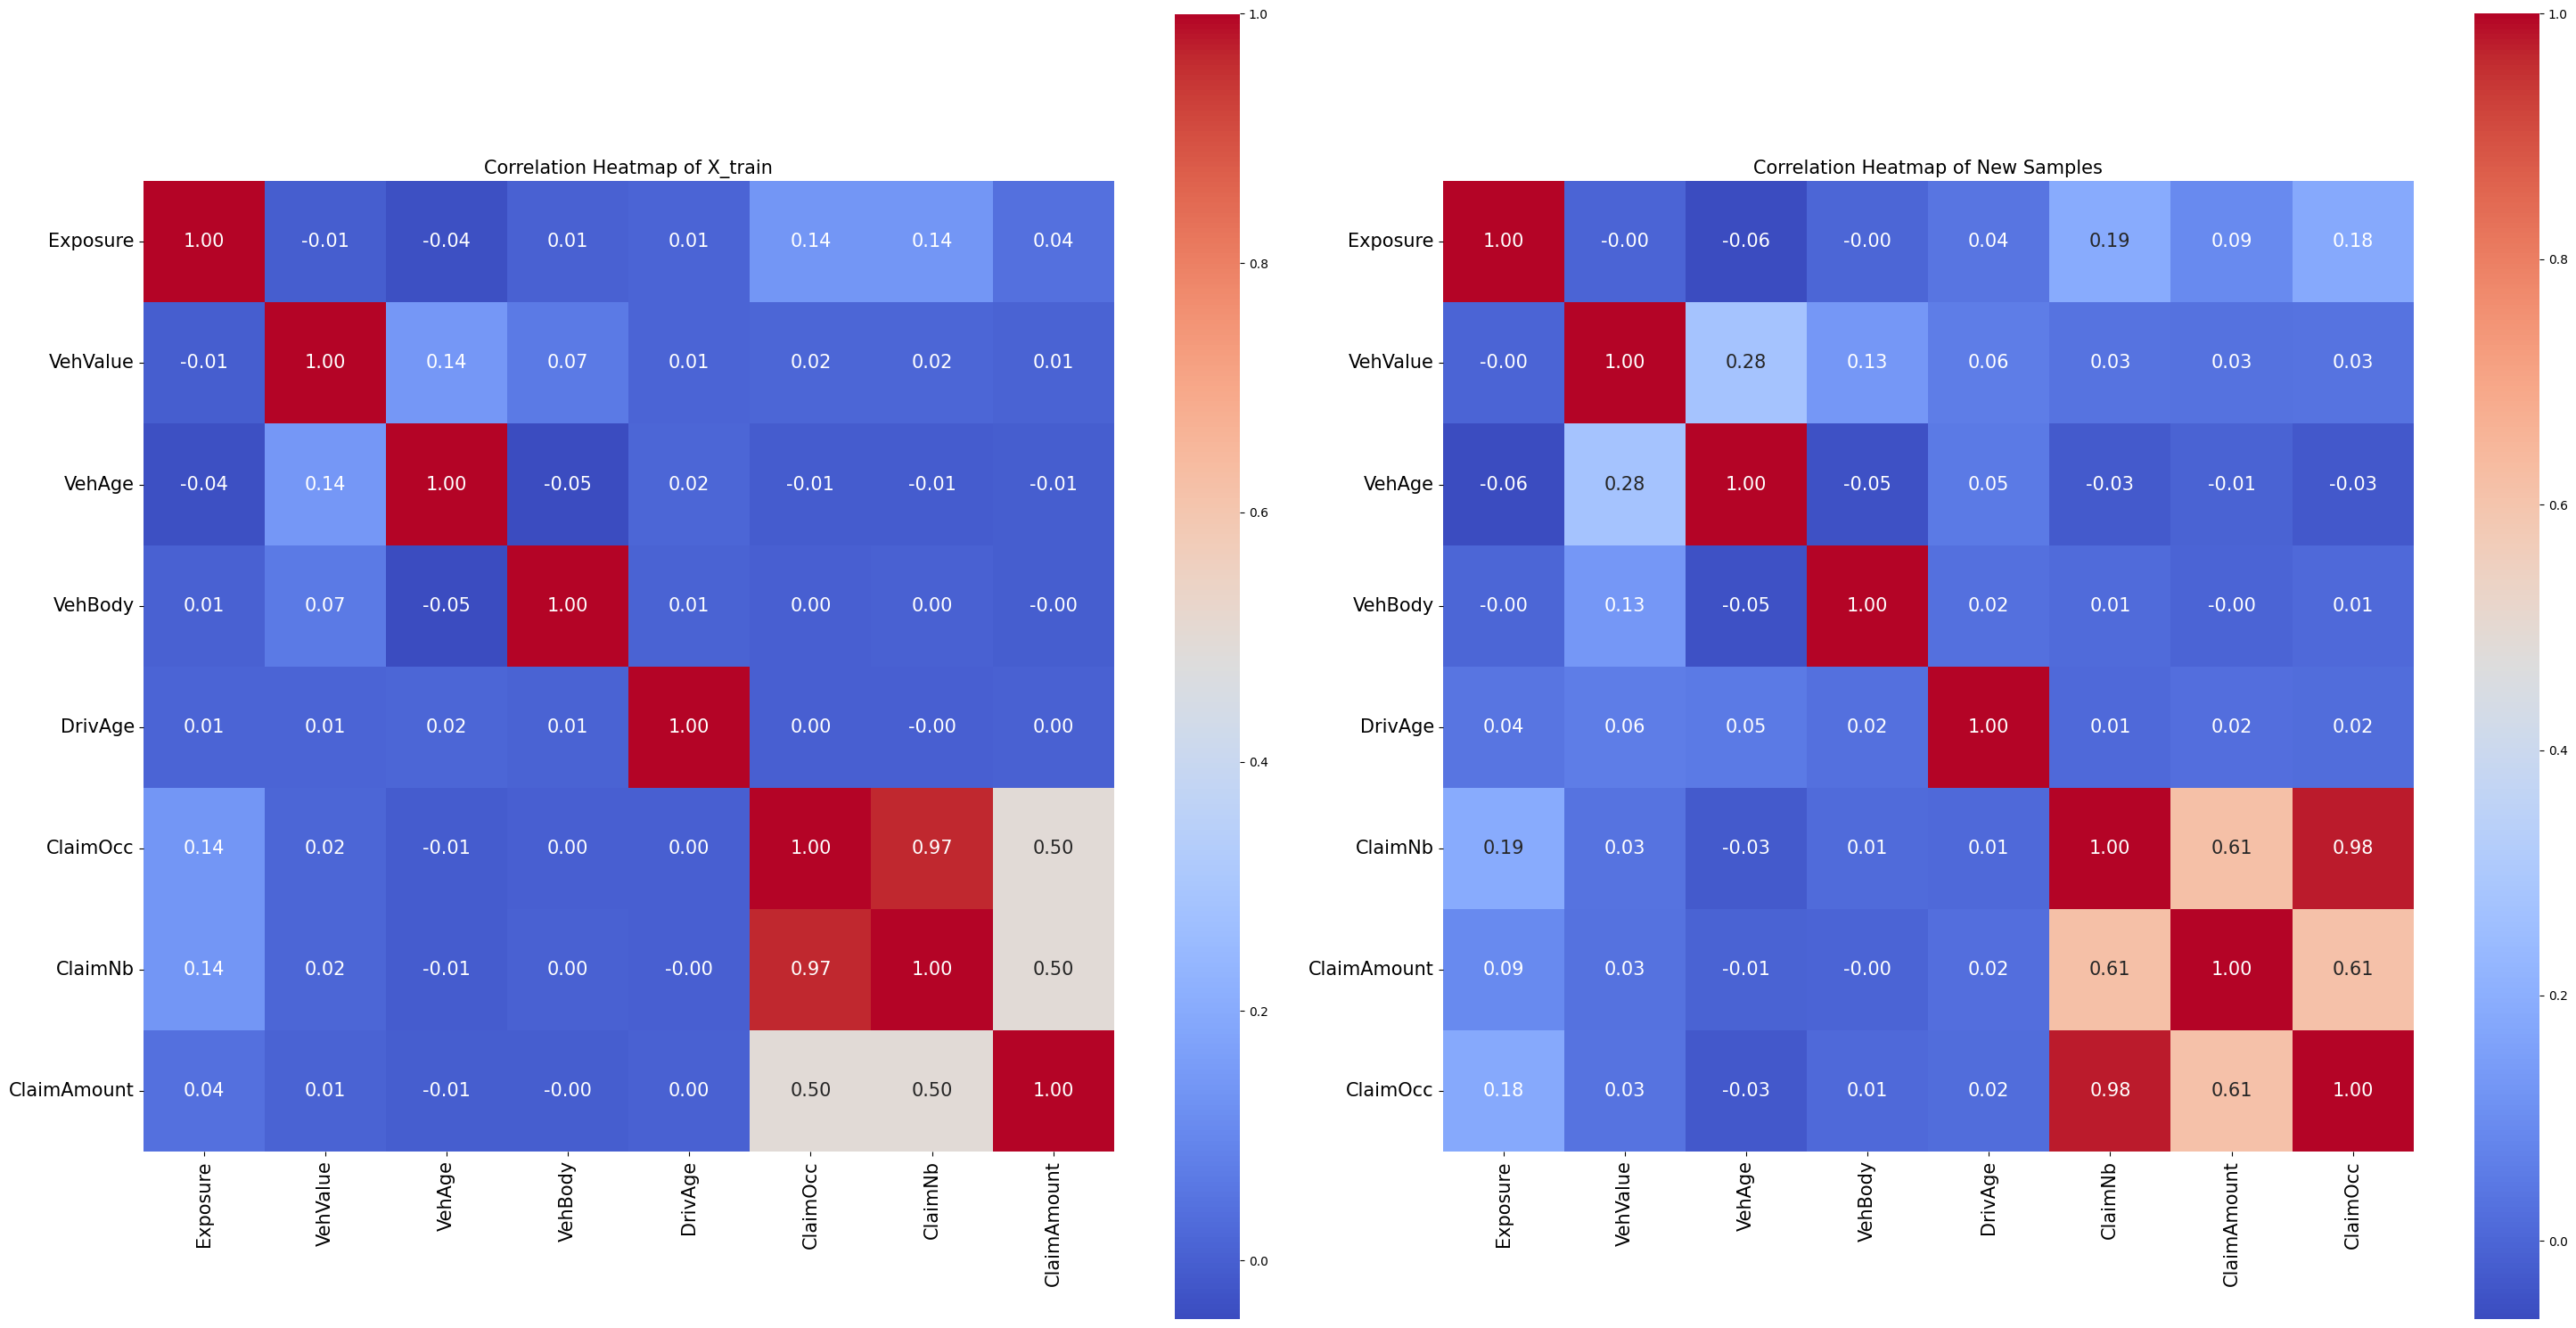

In [41]:
# Compute correlation matrices
corr_matrix_X_train = X_train.corr()
corr_matrix_new_samples = new_samples_df.corr()

# Set figure size
plt.figure(figsize=(30,15))

# a subplot grid
# Parameters (1, 2, 1) implies 1 row, 2 columns, and this plot is the 1st plot.
plt.subplot(1, 2, 1) # Subplot 1
sns.heatmap(corr_matrix_X_train, square=True, annot=True, cmap='coolwarm', fmt='.2f',annot_kws={"size": 15})
plt.title('Correlation Heatmap of X_train', size=15)
plt.yticks(rotation=0,fontsize=15)
plt.xticks(rotation=90,fontsize=15)

# another subplot for the second heatmap
plt.subplot(1, 2, 2) # Subplot 2
sns.heatmap(corr_matrix_new_samples, square=True, annot=True, cmap='coolwarm', fmt='.2f',annot_kws={"size": 15})
plt.title('Correlation Heatmap of New Samples', size=15)
plt.yticks(rotation=0,fontsize=15)
plt.xticks(rotation=90,fontsize=15)

# Display the plot
plt.tight_layout()
plt.show()

### Statistical Analysis

In [42]:
# Kolmogorov-Smirnov test
for column in X_train.columns:
    original = X_train[column].values
    generated = new_samples_df[column].values
    statistic, p_value = ks_2samp(original, generated)
    print(f"KS Test for {column}: Statistic={statistic}, P-value={p_value}")

KS Test for Exposure: Statistic=0.14863090772693172, P-value=0.0
KS Test for VehValue: Statistic=0.20273818454613654, P-value=0.0
KS Test for VehAge: Statistic=0.13246436609152287, P-value=0.0
KS Test for VehBody: Statistic=0.20977119279819956, P-value=0.0
KS Test for DrivAge: Statistic=0.13552138034508626, P-value=0.0
KS Test for ClaimOcc: Statistic=0.0, P-value=1.0
KS Test for ClaimNb: Statistic=0.0006376594148537196, P-value=1.0
KS Test for ClaimAmount: Statistic=0.014309827456864155, P-value=3.5884772606863696e-05


### PCA Analysis

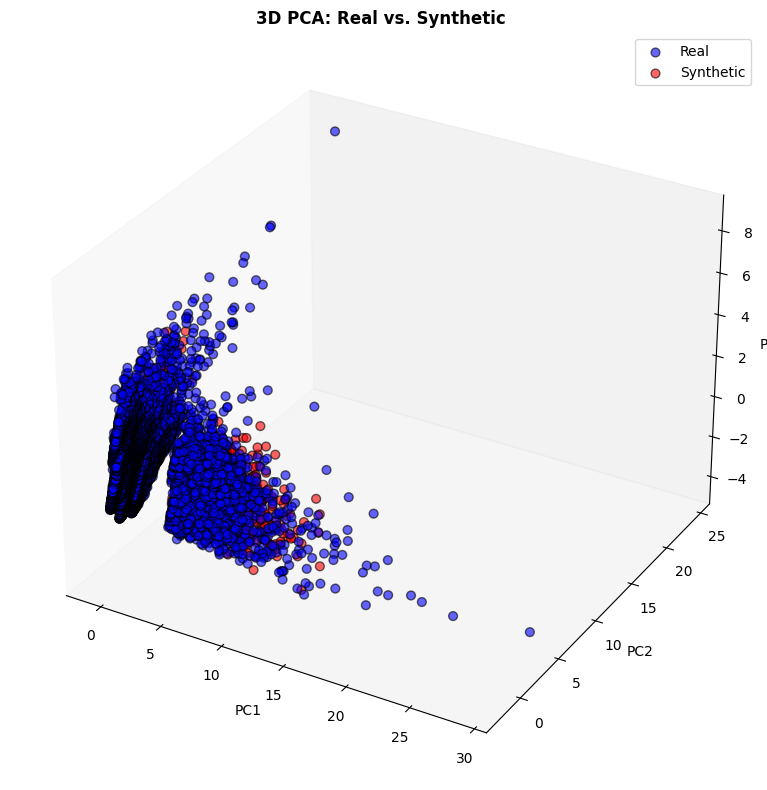

In [43]:
pca_visual_comparison_3d(X_train, synthetic_data, var='d1')

### UMAP Analysis

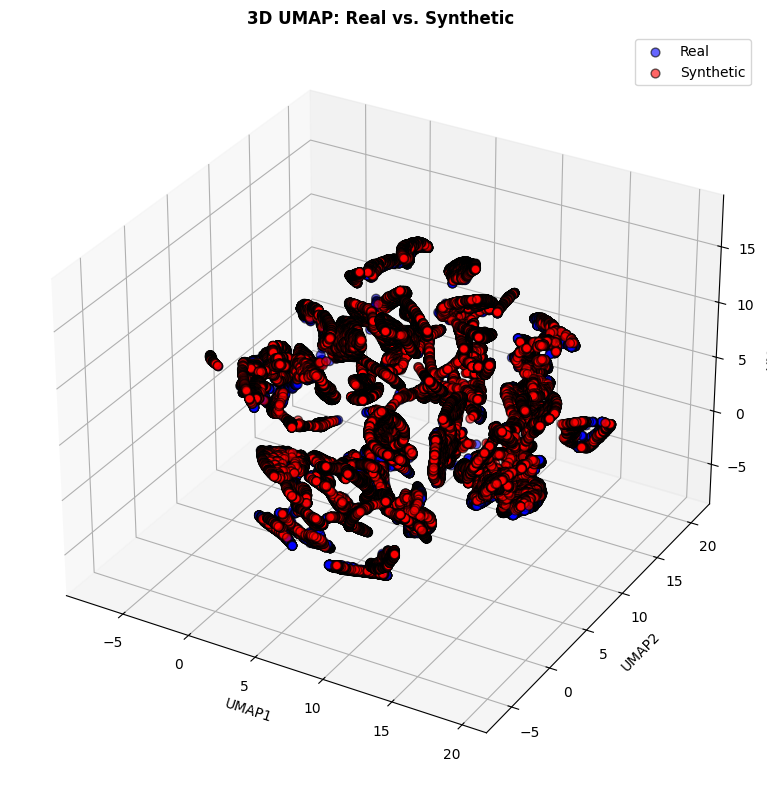

In [44]:
umap_visual_comparison_3d(X_train, synthetic_data, var='d1')

### GLM Frequency Analysis

In [45]:
# Baseline frequency model
results_frequency_1 = run_glm_frequency_analysis(X_train, X_test, label="Baseline")



Fold 1 Poisson Deviance Score: 1.6449
Fold 2 Poisson Deviance Score: 1.3600
Fold 3 Poisson Deviance Score: 1.0406
Fold 4 Poisson Deviance Score: 1.8230
Fold 5 Poisson Deviance Score: 1.3053
Average cross-validation Poisson Deviance Score: 1.4348
Standard Deviation of CV Scores: 0.2730
Train Poisson Deviance: 1.4345
Test Poisson Deviance: 1.7412


In [46]:
# Using synthetic sample data with exposure clipping
results_frequency_2 = run_glm_frequency_analysis(new_samples_df, X_test, clip_exposure=True, label="Synthetic Clipped")


Fold 1 Poisson Deviance Score: 0.7231
Fold 2 Poisson Deviance Score: 0.8087
Fold 3 Poisson Deviance Score: 0.7255
Fold 4 Poisson Deviance Score: 0.7019
Fold 5 Poisson Deviance Score: 1.0263
Average cross-validation Poisson Deviance Score: 0.7971
Standard Deviation of CV Scores: 0.1203
Train Poisson Deviance: 0.7968
Test Poisson Deviance: 1.7389


### GLM Cost Analysis

In [47]:
results_cost_1 = run_glm_cost_analysis(X_train, X_test)


Fold 1 Gamma Deviance Score: 1.5168
Fold 2 Gamma Deviance Score: 1.6114
Fold 3 Gamma Deviance Score: 1.4364
Fold 4 Gamma Deviance Score: 1.5851
Fold 5 Gamma Deviance Score: 1.6609
Average cross-validation Gamma Deviance Score: 1.562124702490075
Standard Deviation of CV Scores: 0.0781914317274654
Train Gamma Deviance: 1.5535
Test Gamma Deviance: 1.7265


In [48]:
results_cost_2 = run_glm_cost_analysis(new_samples_df, X_test, is_sampled=True)


Fold 1 Gamma Deviance Score: 0.9943
Fold 2 Gamma Deviance Score: 1.0050
Fold 3 Gamma Deviance Score: 1.0229
Fold 4 Gamma Deviance Score: 1.0841
Fold 5 Gamma Deviance Score: 1.0076
Average cross-validation Gamma Deviance Score: 1.0227708596653178
Standard Deviation of CV Scores: 0.03200857380615952
Train Gamma Deviance: 1.0194
Test Gamma Deviance: 1.7470


### Feature Importance Analysis


--- SHAP Feature Importance for Frequency Model ---


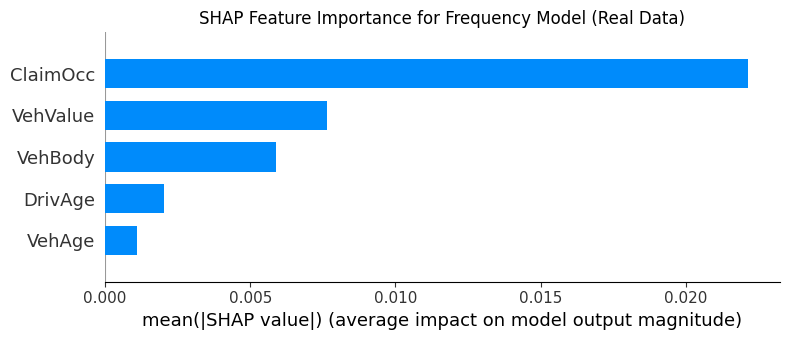


--- SHAP Feature Importance for Severity Model ---


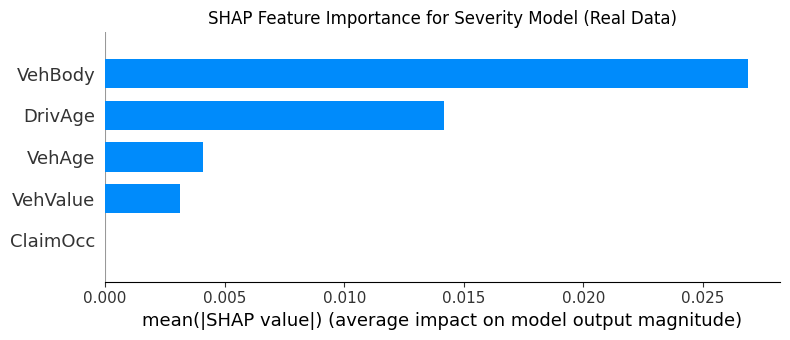

In [49]:
# --- SHAP Feature Importance for Frequency ---
print("\n--- SHAP Feature Importance for Frequency Model ---")

# Prepare data for frequency model SHAP
X_train_freq = X_train.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq = X_train['ClaimNb']
sample_weight_freq = X_train['Exposure']

X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
mask_train_freq = sample_weight_freq > 0
X_train_freq_filtered = X_train_freq[mask_train_freq]
y_train_freq_filtered = y_train_freq[mask_train_freq]
sample_weight_freq_filtered = sample_weight_freq[mask_train_freq]

# Ensure X_test_freq also only contains rows where Exposure > 0
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]


# Plot SHAP for Frequency
plot_glm_shap_importance(
    X_train=X_train_freq_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_filtered / sample_weight_freq_filtered, # Target is rate (ClaimNb / Exposure)
    sample_weight=sample_weight_freq_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Real Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity ---
print("\n--- SHAP Feature Importance for Severity Model ---")

# Prepare data for severity model SHAP
X_train_cost_prep = X_train[X_train['ClaimAmount'] != 0].copy()
X_test_cost_prep = X_test[X_test['ClaimAmount'] != 0].copy()

X_train_sev = X_train_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev = X_train_cost_prep['ClaimAmount'] / X_train_cost_prep['ClaimNb']
sample_weight_sev = X_train_cost_prep['ClaimNb'] # Number of claims is the weight for severity

X_test_sev = X_test_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')

# Plot SHAP for Severity
plot_glm_shap_importance(
    X_train=X_train_sev,
    X_test=X_test_sev,
    y_train=y_train_sev,
    sample_weight=sample_weight_sev,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Real Data)",
    max_display=10
)


--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---


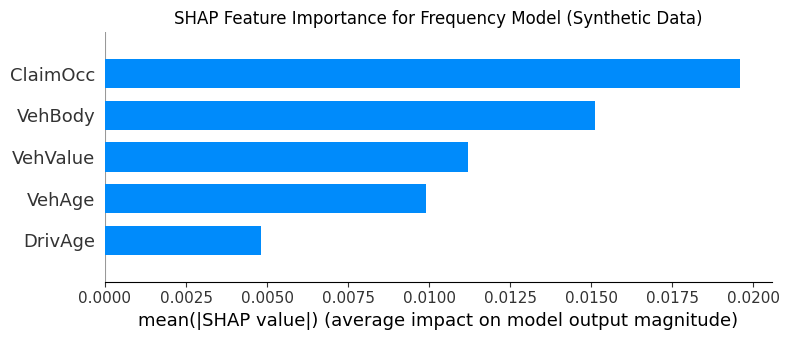


--- SHAP Feature Importance for Severity Model (Synthetic Data) ---


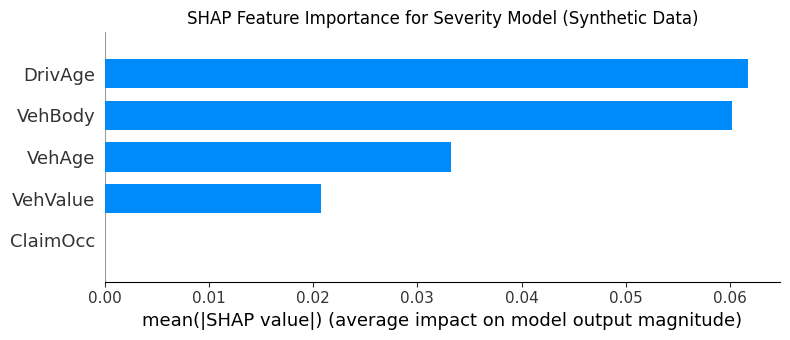

In [50]:
# --- SHAP Feature Importance for Frequency (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---")

# Prepare data for frequency model SHAP using synthetic data
X_train_freq_synth = new_samples_df.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq_synth = new_samples_df['ClaimNb']
sample_weight_freq_synth = new_samples_df['Exposure']

# X_test_freq is the same as before (real test data)
X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
mask_train_freq_synth = sample_weight_freq_synth > 0
X_train_freq_synth_filtered = X_train_freq_synth[mask_train_freq_synth]
y_train_freq_synth_filtered = y_train_freq_synth[mask_train_freq_synth]
sample_weight_freq_synth_filtered = sample_weight_freq_synth[mask_train_freq_synth]

# Ensure X_test_freq also only contains rows where Exposure > 0
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]

# Plot SHAP for Frequency (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_freq_synth_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_synth_filtered / sample_weight_freq_synth_filtered, # Target is rate
    sample_weight=sample_weight_freq_synth_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Synthetic Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Severity Model (Synthetic Data) ---")

# Prepare data for severity model SHAP using synthetic data
X_train_cost_prep_synth = new_samples_df[new_samples_df['ClaimAmount'] != 0].copy()
X_test_cost_prep_synth = X_test[X_test['ClaimAmount'] != 0].copy() # Keep using real test data for explanation

X_train_sev_synth = X_train_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev_synth = X_train_cost_prep_synth['ClaimAmount'] / X_train_cost_prep_synth['ClaimNb']
sample_weight_sev_synth = X_train_cost_prep_synth['ClaimNb'] # Number of claims is the weight for severity

X_test_sev_synth = X_test_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')


# Plot SHAP for Severity (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_sev_synth,
    X_test=X_test_sev_synth,
    y_train=y_train_sev_synth,
    sample_weight=sample_weight_sev_synth,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Synthetic Data)",
    max_display=10
)

### Upload dataset and data handling

In [51]:
#---------------------
# D2
#---------------------
df2=pd.read_csv('/content/swmotorcycle.csv')

In [52]:
print(df2.shape)

(64548, 9)


In [53]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64548 entries, 0 to 64547
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OwnerAge     64548 non-null  int64  
 1   Gender       64548 non-null  object 
 2   Area         64548 non-null  object 
 3   RiskClass    64548 non-null  object 
 4   VehAge       64548 non-null  int64  
 5   BonusClass   64548 non-null  object 
 6   Exposure     64548 non-null  float64
 7   ClaimNb      64548 non-null  int64  
 8   ClaimAmount  64548 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 4.4+ MB
None


In [54]:
print(df2.columns)

Index(['OwnerAge', 'Gender', 'Area', 'RiskClass', 'VehAge', 'BonusClass',
       'Exposure', 'ClaimNb', 'ClaimAmount'],
      dtype='object')


In [55]:
df2.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount
0,0,Male,Central parts of Sweden's three largest cities,EV ratio 13-15,12,BM1,0.175342,0,0
1,4,Male,Lesser towns except Gotland; Northern towns,EV ratio 20-24,9,BM1,0.000000,0,0
2,5,Female,Lesser towns except Gotland; Northern towns,EV ratio 9-12,18,BM1,0.454795,0,0
3,5,Female,Small towns; countryside except Gotland; North...,EV ratio <5,25,BM1,0.172603,0,0
4,6,Female,Suburbs; middle-sized cities,EV ratio <5,26,BM1,0.180822,0,0


In [56]:
df2_duplicated_rows=df2[df2.duplicated()]
df2_duplicated_rows

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount


In [57]:
df2=df2.drop_duplicates()

In [58]:
df2_duplicated_col=df2.columns[df2.columns.duplicated()]
df2_duplicated_col

Index([], dtype='object')

In [59]:
missing=df2.isnull().sum()/df2.shape[0]*100
missing

,0
OwnerAge,0.0
Gender,0.0
Area,0.0
RiskClass,0.0
VehAge,0.0
BonusClass,0.0
Exposure,0.0
ClaimNb,0.0
ClaimAmount,0.0


In [60]:
# add ClaimOcc feature
df_2 = df2.copy()
df_2['ClaimOcc'] = np.where(df_2['ClaimNb'] > 0, 1, 0)
# Feature transformation
df_2['Exposure'] = df_2['Exposure'].clip(upper=1)
df_2['VehAge'] = df_2['VehAge'].clip(upper=20)

### Encoding

In [61]:
print(df_2['Gender'].unique())
print(df_2['Area'].unique())
print(df_2['RiskClass'].unique())
print(df_2['BonusClass'].unique())


['Male' 'Female']
["Central parts of Sweden's three largest cities"
 'Lesser towns except Gotland; Northern towns'
 'Small towns; countryside except Gotland; Northern towns'
 'Suburbs; middle-sized cities' 'Northern countryside' 'Northern towns'
 "Gotland (Sweden's largest island)"]
['EV ratio 13-15' 'EV ratio 20-24' 'EV ratio 9-12' 'EV ratio <5'
 'EV ratio 6-8' 'EV ratio 16-19' 'EV ratio >25']
['BM1' 'BM2' 'BM3' 'BM4' 'BM7' 'BM5' 'BM6']


In [62]:
df2_encod=df_2.copy()
df2_encod=df2_encod.drop(columns=['Gender'])
# RiskClass
RiskClass_group = {'EV ratio 13-15':'1','EV ratio 20-24':'2','EV ratio 9-12':'3','EV ratio <5':'4','EV ratio 6-8':'5',\
                   'EV ratio 16-19':'6','EV ratio >25':'7'}
df2_encod['RiskClass'] = df2_encod['RiskClass'].map(RiskClass_group)
df2_encod['RiskClass']= df2_encod['RiskClass'].astype(int)
# BonusClass
BonusClass_group = {'BM1':'1','BM2':'2','BM3':'3','BM4':'4','BM5':'5','BM6':'6','BM7':'7'}
df2_encod['BonusClass'] = df2_encod['BonusClass'].map(BonusClass_group)
df2_encod['BonusClass']= df2_encod['BonusClass'].astype(int)
# Area
Area_group = {"Central parts of Sweden's three largest cities":'1','Lesser towns except Gotland; Northern towns':'2',\
              'Small towns; countryside except Gotland; Northern towns':'3','Suburbs; middle-sized cities':'4',\
              'Northern countryside':'5','Northern towns':'6',"Gotland (Sweden's largest island)":'7'}
df2_encod['Area'] = df2_encod['Area'].map(Area_group)
df2_encod['Area']= df2_encod['Area'].astype(int)
# Gender
#Gender_group = {'Female':'0','Male':'1'}
#df2_encod['Gender'] = df2_encod['Gender'].map(Gender_group)
#df2_encod['Gender']= df2_encod['Gender'].astype(int)




In [63]:
df2_encod.head()

,OwnerAge,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount,ClaimOcc
0,0,1,1,12,1,0.175342,0,0,0
1,4,2,2,9,1,0.000000,0,0,0
2,5,2,3,18,1,0.454795,0,0,0
3,5,3,4,20,1,0.172603,0,0,0
4,6,4,4,20,1,0.180822,0,0,0


### Split dataset

In [64]:
# Split the dataset into train/test split
X_train, X_test = train_test_split(df2_encod, test_size=0.2, random_state=0)

In [65]:
X_train.shape

(51638, 9)

### Build a CVAE

In [66]:
cvae_d2, encoder_d2, decoder_d2, X_input_d2, means_d2, stds_corrected_d2, features_d2 =train_cvae_model(
    X_train=X_train,
    condition_col='ClaimOcc',
    target_discrete='ClaimNb',
    target_continuous='ClaimAmount',
    hidden_dim=64,
    latent_dim=5,
    embed_dim=64,
    num_heads=4,
    ff_dim=64,
    num_transformer_blocks=3,
    epochs=30,
    batch_size=128,
    penalty_weight_nb=1.0,
    penalty_weight_amt=1.0)

Training CVAE on input shape: (51638, 9)
Epoch 1/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 7.0302
Epoch 2/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 5.6433
Epoch 3/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 5.5313
Epoch 4/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 5.4359
Epoch 5/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 5.3268
Epoch 6/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 5.2652
Epoch 7/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 5.2220
Epoch 8/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 5.2261
Epoch 9/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 5.2051
Epoch 10/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 5.2047
Epoch 11/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 5.1615
Epoch 12/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 5.1542
Epoch 13/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 5.1392
Epoch 14/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 5.2518


### Generate Samples

In [67]:
synthetic_data = generate_cvae_synthetic_data(
    cvae_model=cvae_d2,
    num_samples=len(X_train),
    claim_occ_values=[0, 1],
    feature_names=features_d2,         # excludes the condition column
    means=means_d2,                    # from training
    stds_corrected=stds_corrected_d2,  # from training
    X_train=X_train,
    condition_col='ClaimOcc',
    target_discrete='ClaimNb',
    target_continuous='ClaimAmount',
    latent_dim=5,
    condition_dim=1,
    columns_to_round=['RiskClass', 'Area','BonusClass']
)

### Use Generate Samples Dataframe

In [68]:
new_samples_df=synthetic_data.copy()

In [69]:
new_samples_df.to_csv('d2_ctvae_gender_encod.csv')

In [70]:
df2_decod=new_samples_df.copy()
# RiskClass
RiskClass_group = {1:'EV ratio 13-15',2:'EV ratio 20-24',3:'EV ratio 9-12',4:'EV ratio <5',5:'EV ratio 6-8',\
                   6:'EV ratio 16-19',7:'EV ratio >25'}
df2_decod['RiskClass'] = df2_decod['RiskClass'].map(RiskClass_group)
# BonusClass
BonusClass_group = {1:'BM1', 2:'BM2',3: 'BM3', 4:'BM4',5:'BM5',6:'BM6',7:'BM7'}
df2_decod['BonusClass'] = df2_decod['BonusClass'].map(BonusClass_group)
# Area
Area_group = {1:"Central parts of Sweden's three largest cities",2:'Lesser towns except Gotland; Northern towns',\
              3:'Small towns; countryside except Gotland; Northern towns',4:'Suburbs; middle-sized cities',\
              5:'Northern countryside',6:'Northern towns',7:"Gotland (Sweden's largest island)"}
df2_decod['Area'] = df2_decod['Area'].map(Area_group)
# Gender
#Gender_group = {0:'Female',1:'Male'}
#df2_decod['Gender'] = df2_decod['Gender'].map(Gender_group)


In [71]:
df2_decod.to_csv('d2_ctvae_gender.csv')

### Data Comparison

In [72]:
X_train.head()

,OwnerAge,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount,ClaimOcc
17537,32,4,2,10,4,0.668493,0,0,0
36594,46,4,6,16,3,1.000000,0,0,0
49674,53,1,6,14,2,0.495890,0,0,0
60665,62,2,3,14,3,0.498630,0,0,0
28321,42,4,3,15,2,0.961644,0,0,0


In [73]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
OwnerAge,51638.0,42.381250,12.979286,0.0,31.000000,44.000000,52.0,92.0
Area,51638.0,2.973643,1.253283,1.0,2.000000,3.000000,4.0,7.0
RiskClass,51638.0,3.356714,1.747525,1.0,2.000000,3.000000,5.0,7.0
VehAge,51638.0,11.114722,6.365856,0.0,5.000000,12.000000,16.0,20.0
BonusClass,51638.0,4.020508,2.364091,1.0,2.000000,4.000000,7.0,7.0
Exposure,51638.0,0.687829,0.332135,0.0,0.463014,0.821918,1.0,1.0
ClaimNb,51638.0,0.010535,0.105824,0.0,0.000000,0.000000,0.0,2.0
ClaimAmount,51638.0,260.434583,4748.164398,0.0,0.000000,0.000000,0.0,365347.0
ClaimOcc,51638.0,0.010148,0.100224,0.0,0.000000,0.000000,0.0,1.0


In [74]:
new_samples_df.head()

,OwnerAge,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount,ClaimOcc
0,37.071529,3,2,13.210011,3,0.693739,0.0,0.0,0
1,36.077610,2,2,14.557658,6,0.858299,0.0,0.0,0
2,32.032581,3,4,3.514707,2,0.355086,0.0,0.0,0
3,52.959419,3,4,12.666460,7,0.991917,0.0,0.0,0
4,36.728046,4,3,16.773001,6,0.989079,0.0,0.0,0


In [75]:
new_samples_df.describe().T

,count,mean,std,min,25%,50%,75%,max
OwnerAge,51638.0,41.298843,9.103179,16.966236,34.483662,41.920195,48.286685,67.490646
Area,51638.0,2.975038,0.907189,1.000000,2.000000,3.000000,3.000000,7.000000
RiskClass,51638.0,3.392347,1.328648,1.000000,2.000000,3.000000,4.000000,7.000000
VehAge,51638.0,11.020202,4.670255,0.382633,7.055903,11.472309,15.221920,19.865742
BonusClass,51638.0,4.037995,1.729928,0.000000,2.000000,4.000000,6.000000,11.000000
Exposure,51638.0,0.687666,0.242916,0.000000,0.511416,0.753965,0.895797,1.000000
ClaimNb,51638.0,0.010148,0.100395,0.000000,0.000000,0.000000,0.000000,2.000000
ClaimAmount,51638.0,395.860443,4852.140625,0.000000,0.000000,0.000000,0.000000,128391.968750
ClaimOcc,51638.0,0.010148,0.100224,0.000000,0.000000,0.000000,0.000000,1.000000


In [76]:
# Check for consistency
consistent_zeros = ((X_train["ClaimNb"] == 0) & (X_train["ClaimOcc"] == 0) & (X_train["ClaimAmount"] == 0)).sum()
consistent_positives = ((X_train["ClaimNb"] > 0) & (X_train["ClaimOcc"] > 0) & (X_train["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 51114
Records where all three are positive: 524


In [77]:
# Check for consistency
consistent_zeros = ((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)).sum()
consistent_positives = ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 51114
Records where all three are positive: 522


In [78]:
# Find inconsistencies
inconsistent_records = new_samples_df[
    ~(((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)) |
      ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)))
]

print(f"Number of inconsistent records: {len(inconsistent_records)}")
print(inconsistent_records.head())  # Show a few inconsistent rows

Number of inconsistent records: 2
        OwnerAge  Area  RiskClass     VehAge  BonusClass  Exposure  ClaimNb  \
24680  42.262947     3          6  11.082331           6  0.763635      1.0   
43376  49.094845     2          2   9.681414          10  0.976987      0.0   

       ClaimAmount  ClaimOcc  
24680          0.0         1  
43376          0.0         1  


### Visual Comparison

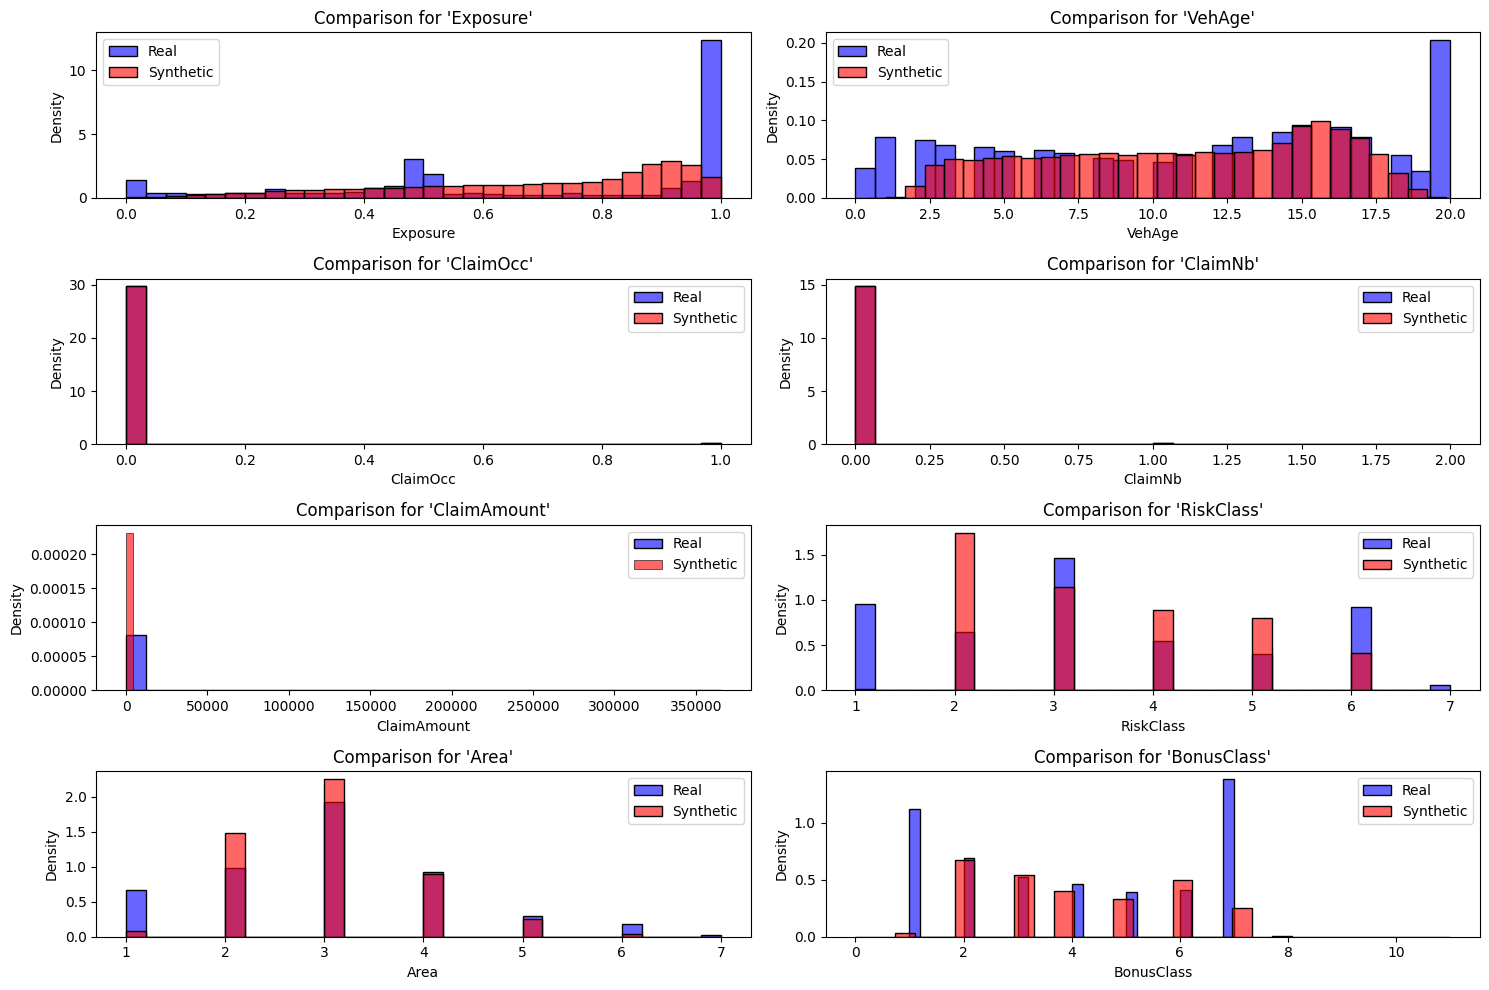

In [79]:
# Compare selected variables using histograms
compare_real_vs_synthetic(
    real_df=X_train,
    synthetic_df=synthetic_data,
    columns=['Exposure','VehAge','ClaimOcc','ClaimNb', 'ClaimAmount', 'RiskClass', 'Area','BonusClass'],
    kind='hist'
)


### Statistical Analysis

In [80]:
# Kolmogorov-Smirnov test
for column in X_train.columns:
    original = X_train[column].values
    generated = new_samples_df[column].values
    statistic, p_value = ks_2samp(original, generated)
    print(f"KS Test for {column}: Statistic={statistic}, P-value={p_value}")

KS Test for OwnerAge: Statistic=0.1354235253108177, P-value=0.0
KS Test for Area: Statistic=0.1161935009101824, P-value=3.816869939249291e-304
KS Test for RiskClass: Statistic=0.1898795460707231, P-value=0.0
KS Test for VehAge: Statistic=0.16935202757659085, P-value=0.0
KS Test for BonusClass: Statistic=0.2138928695921608, P-value=0.0
KS Test for Exposure: Statistic=0.36750067779542195, P-value=0.0
KS Test for ClaimNb: Statistic=0.0003679460862155981, P-value=1.0
KS Test for ClaimAmount: Statistic=0.003834385530036122, P-value=0.8407875878061922
KS Test for ClaimOcc: Statistic=0.0, P-value=1.0


### PCA Analysis

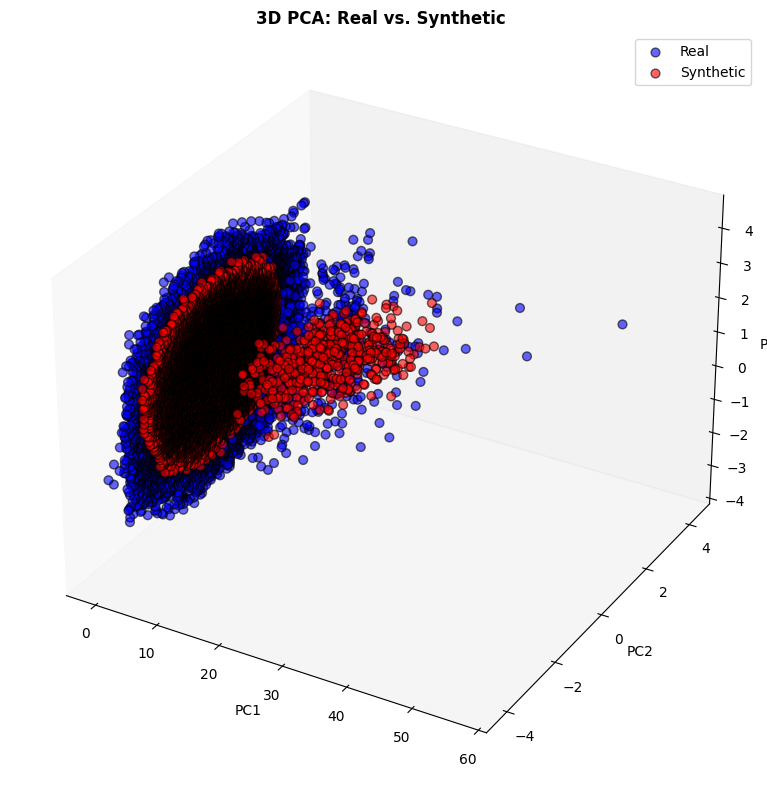

In [81]:
pca_visual_comparison_3d(X_train, synthetic_data, var='d2')

### UMAP Analysis

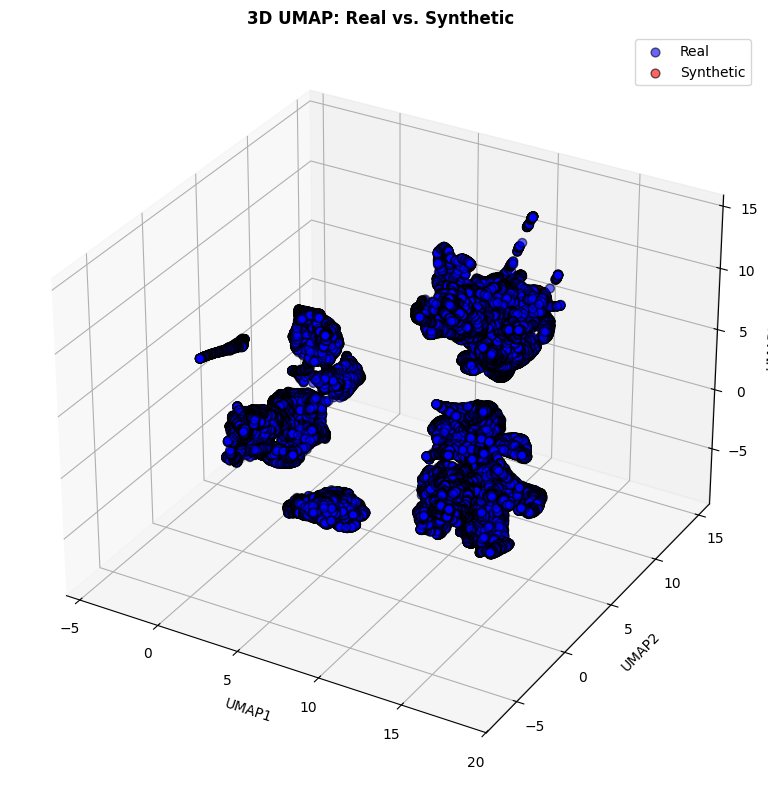

In [82]:
umap_visual_comparison_3d(X_train, synthetic_data, var='d2')

### GLM Frequency Analysis

In [83]:
# Baseline frequency model
results_frequency_3 = run_glm_frequency_analysis(X_train, X_test, label="Baseline")


Fold 1 Poisson Deviance Score: 0.2113
Fold 2 Poisson Deviance Score: 0.2744
Fold 3 Poisson Deviance Score: 0.3212
Fold 4 Poisson Deviance Score: 0.3262
Fold 5 Poisson Deviance Score: 0.2611
Average cross-validation Poisson Deviance Score: 0.2788
Standard Deviation of CV Scores: 0.0423
Train Poisson Deviance: 0.2788
Test Poisson Deviance: 0.4368


In [84]:
# Using synthetic sample data with exposure clipping
results_frequency_4 = run_glm_frequency_analysis(new_samples_df, X_test, clip_exposure=True, label="Synthetic Clipped")


Fold 1 Poisson Deviance Score: 0.1584
Fold 2 Poisson Deviance Score: 0.1385
Fold 3 Poisson Deviance Score: 0.1518
Fold 4 Poisson Deviance Score: 0.1783
Fold 5 Poisson Deviance Score: 0.1824
Average cross-validation Poisson Deviance Score: 0.1619
Standard Deviation of CV Scores: 0.0164
Train Poisson Deviance: 0.1617
Test Poisson Deviance: 0.4299


### GLM Cost Analysis

In [85]:
results_cost_3 = run_glm_cost_analysis(X_train, X_test)


Fold 1 Gamma Deviance Score: 1.8636
Fold 2 Gamma Deviance Score: 1.8796
Fold 3 Gamma Deviance Score: 1.6975
Fold 4 Gamma Deviance Score: 1.8396
Fold 5 Gamma Deviance Score: 1.8481
Average cross-validation Gamma Deviance Score: 1.8256804262526054
Standard Deviation of CV Scores: 0.06553159051214787
Train Gamma Deviance: 1.7618
Test Gamma Deviance: 1.7255


In [86]:
results_cost_4 = run_glm_cost_analysis(new_samples_df, X_test, is_sampled=True)

Fold 1 Gamma Deviance Score: 0.2179
Fold 2 Gamma Deviance Score: 0.2156
Fold 3 Gamma Deviance Score: 0.2350
Fold 4 Gamma Deviance Score: 0.2189
Fold 5 Gamma Deviance Score: 0.1418
Average cross-validation Gamma Deviance Score: 0.20583143640582252
Standard Deviation of CV Scores: 0.032760519472605915
Train Gamma Deviance: 0.2046
Test Gamma Deviance: 4.5950


### Feature Importance Analysis


--- SHAP Feature Importance for Frequency Model ---


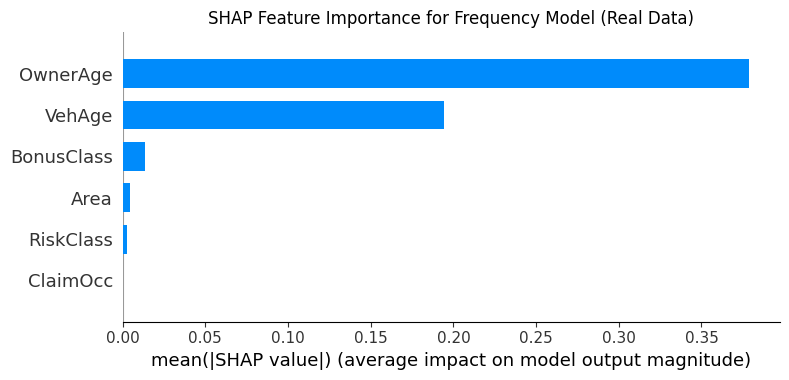


--- SHAP Feature Importance for Severity Model ---


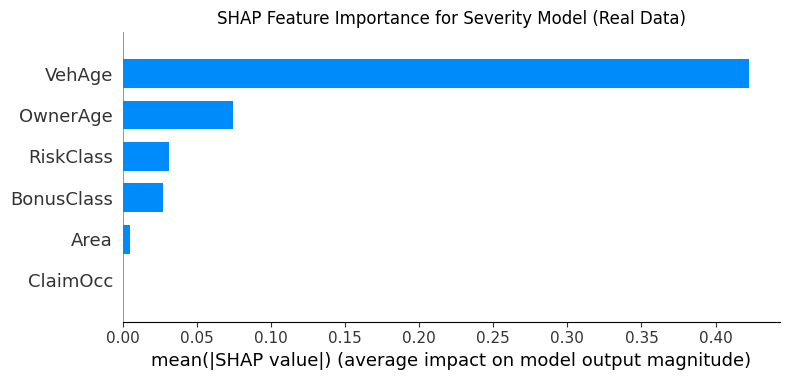

In [87]:
# --- SHAP Feature Importance for Frequency ---
print("\n--- SHAP Feature Importance for Frequency Model ---")

# Prepare data for frequency model SHAP
X_train_freq = X_train.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq = X_train['ClaimNb']
sample_weight_freq = X_train['Exposure']

X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
mask_train_freq = sample_weight_freq > 0
X_train_freq_filtered = X_train_freq[mask_train_freq]
y_train_freq_filtered = y_train_freq[mask_train_freq]
sample_weight_freq_filtered = sample_weight_freq[mask_train_freq]

# Ensure X_test_freq also only contains rows where Exposure > 0
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]


# Plot SHAP for Frequency
plot_glm_shap_importance(
    X_train=X_train_freq_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_filtered / sample_weight_freq_filtered, # Target is rate (ClaimNb / Exposure)
    sample_weight=sample_weight_freq_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Real Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity ---
print("\n--- SHAP Feature Importance for Severity Model ---")

# Prepare data for severity model SHAP
X_train_cost_prep = X_train[X_train['ClaimAmount'] != 0].copy()
X_test_cost_prep = X_test[X_test['ClaimAmount'] != 0].copy()

X_train_sev = X_train_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev = X_train_cost_prep['ClaimAmount'] / X_train_cost_prep['ClaimNb']
sample_weight_sev = X_train_cost_prep['ClaimNb'] # Number of claims is the weight for severity

X_test_sev = X_test_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')

# Plot SHAP for Severity
plot_glm_shap_importance(
    X_train=X_train_sev,
    X_test=X_test_sev,
    y_train=y_train_sev,
    sample_weight=sample_weight_sev,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Real Data)",
    max_display=10
)


--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---


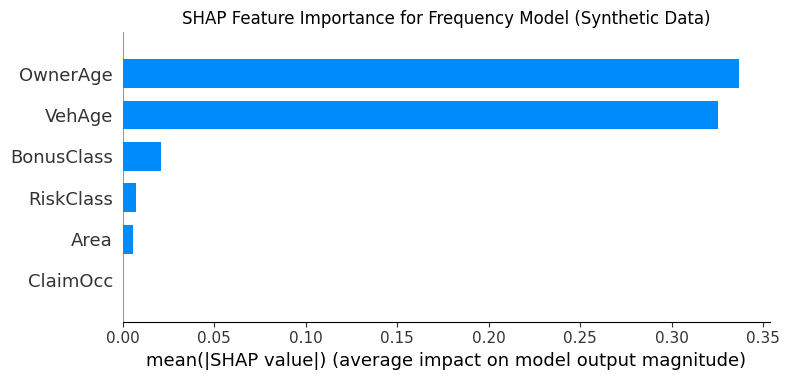


--- SHAP Feature Importance for Severity Model (Synthetic Data) ---


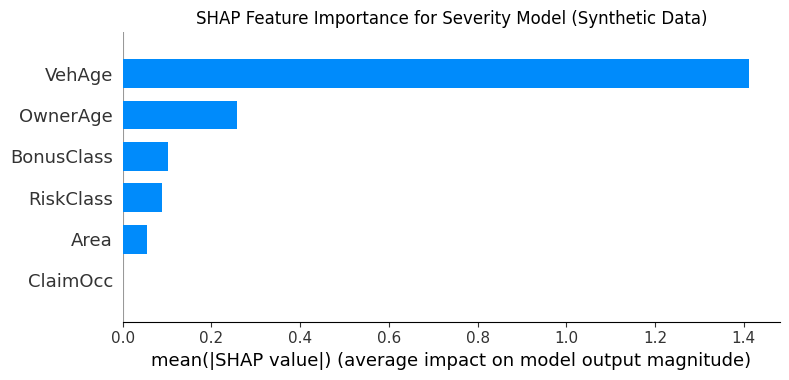

In [88]:
# --- SHAP Feature Importance for Frequency (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---")

# Prepare data for frequency model SHAP using synthetic data
X_train_freq_synth = new_samples_df.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq_synth = new_samples_df['ClaimNb']
sample_weight_freq_synth = new_samples_df['Exposure']

# X_test_freq is the same as before (real test data)
X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
mask_train_freq_synth = sample_weight_freq_synth > 0
X_train_freq_synth_filtered = X_train_freq_synth[mask_train_freq_synth]
y_train_freq_synth_filtered = y_train_freq_synth[mask_train_freq_synth]
sample_weight_freq_synth_filtered = sample_weight_freq_synth[mask_train_freq_synth]

# Ensure X_test_freq also only contains rows where Exposure > 0
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]

# Plot SHAP for Frequency (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_freq_synth_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_synth_filtered / sample_weight_freq_synth_filtered, # Target is rate
    sample_weight=sample_weight_freq_synth_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Synthetic Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Severity Model (Synthetic Data) ---")

# Prepare data for severity model SHAP using synthetic data
X_train_cost_prep_synth = new_samples_df[new_samples_df['ClaimAmount'] != 0].copy()
X_test_cost_prep_synth = X_test[X_test['ClaimAmount'] != 0].copy() # Keep using real test data for explanation

X_train_sev_synth = X_train_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev_synth = X_train_cost_prep_synth['ClaimAmount'] / X_train_cost_prep_synth['ClaimNb']
sample_weight_sev_synth = X_train_cost_prep_synth['ClaimNb'] # Number of claims is the weight for severity

X_test_sev_synth = X_test_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')


# Plot SHAP for Severity (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_sev_synth,
    X_test=X_test_sev_synth,
    y_train=y_train_sev_synth,
    sample_weight=sample_weight_sev_synth,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Synthetic Data)",
    max_display=10
)

### Results

In [89]:
# The dictionary dataset 1
metrics_dict_1 = results_frequency_1[1]
mpd_train_1 = metrics_dict_1['mpd_train']
mpd_test_1 = metrics_dict_1['mpd_test']
print(f"mpd_train_1: {mpd_train_1}")
print(f"mpd_test_1: {mpd_test_1}")

mpd_train_1: 1.4344752025293812
mpd_test_1: 1.7412249669002542


In [90]:
# The dictionary synthetic dataset 1
metrics_dict_2 = results_frequency_2[1]
mpd_train_2 = metrics_dict_2['mpd_train']
mpd_test_2 = metrics_dict_2['mpd_test']
print(f"mpd_train_2: {mpd_train_2}")
print(f"mpd_test_2: {mpd_test_2}")

mpd_train_2: 0.7968233669051126
mpd_test_2: 1.73889991813483


In [91]:
# The dictionary dataset 2
metrics_dict_3 = results_frequency_3[1]
mpd_train_3 = metrics_dict_3['mpd_train']
mpd_test_3 = metrics_dict_3['mpd_test']
print(f"mpd_train_3: {mpd_train_3}")
print(f"mpd_test_3: {mpd_test_3}")

mpd_train_3: 0.2787841637277496
mpd_test_3: 0.43680115478242787


In [92]:
# The dictionary synthetic dataset 2
metrics_dict_4 = results_frequency_4[1]
mpd_train_4 = metrics_dict_4['mpd_train']
mpd_test_4 = metrics_dict_4['mpd_test']
print(f"mpd_train_4: {mpd_train_4}")
print(f"mpd_test_4: {mpd_test_4}")

mpd_train_4: 0.16168967434858106
mpd_test_4: 0.42989620736076106


In [93]:
# The dictionary dataset 1
mgd_train_1 = results_cost_1['mgd_train']
mgd_test_1 = results_cost_1['mgd_test']
print(f"mgd_train_1: {mgd_train_1}")
print(f"mgd_test_1: {mgd_test_1}")

mgd_train_1: 1.5534890842013782
mgd_test_1: 1.7264720753701048


In [94]:
# The dictionary synthetic dataset 1
mgd_train_2 = results_cost_2['mgd_train']
mgd_test_2 = results_cost_2['mgd_test']
print(f"mgd_train_2: {mgd_train_2}")
print(f"mgd_test_2: {mgd_test_2}")

mgd_train_2: 1.0193961219743775
mgd_test_2: 1.7470156083478225


In [95]:
# The dictionary dataset 2
mgd_train_3 = results_cost_3['mgd_train']
mgd_test_3 = results_cost_3['mgd_test']
print(f"mgd_train_3: {mgd_train_3}")
print(f"mgd_test_3: {mgd_test_3}")

mgd_train_3: 1.761785749156575
mgd_test_3: 1.7254639195892414


In [96]:
# The dictionary synthetic dataset 2
mgd_train_4 = results_cost_4['mgd_train']
mgd_test_4 = results_cost_4['mgd_test']
print(f"mgd_train_4: {mgd_train_4}")
print(f"mgd_test_4: {mgd_test_4}")

mgd_train_4: 0.20458820325357194
mgd_test_4: 4.5949837535753595


In [97]:
# Create the DataFrame
results_df1 = {
    'mpd_train': mpd_train_1,
    'mpd_test': mpd_test_1,
    'mgd_train': mgd_train_1,
    'mgd_test': mgd_test_1,
}
results_df2 = {
    'mpd_train': mpd_train_2,
    'mpd_test': mpd_test_2,
    'mgd_train': mgd_train_2,
    'mgd_test': mgd_test_2,
}
results_df3 = {
    'mpd_train': mpd_train_3,
    'mpd_test': mpd_test_3,
    'mgd_train': mgd_train_3,
    'mgd_test': mgd_test_3,
}
results_df4 = {
    'mpd_train': mpd_train_4,
    'mpd_test': mpd_test_4,
    'mgd_train': mgd_train_4,
    'mgd_test': mgd_test_4,
}
d1=pd.DataFrame(results_df1, index=['dataset 1'])
d2=pd.DataFrame(results_df2, index=['synthetic dataset 1'])
d3=pd.DataFrame(results_df3, index=['dataset 2'])
d4=pd.DataFrame(results_df4, index=['synthetic dataset 2'])
df_tot= pd.concat([d1,d2,d3,d4])
df_tot

,mpd_train,mpd_test,mgd_train,mgd_test
dataset 1,1.434475,1.741225,1.553489,1.726472
synthetic dataset 1,0.796823,1.738900,1.019396,1.747016
dataset 2,0.278784,0.436801,1.761786,1.725464
synthetic dataset 2,0.161690,0.429896,0.204588,4.594984


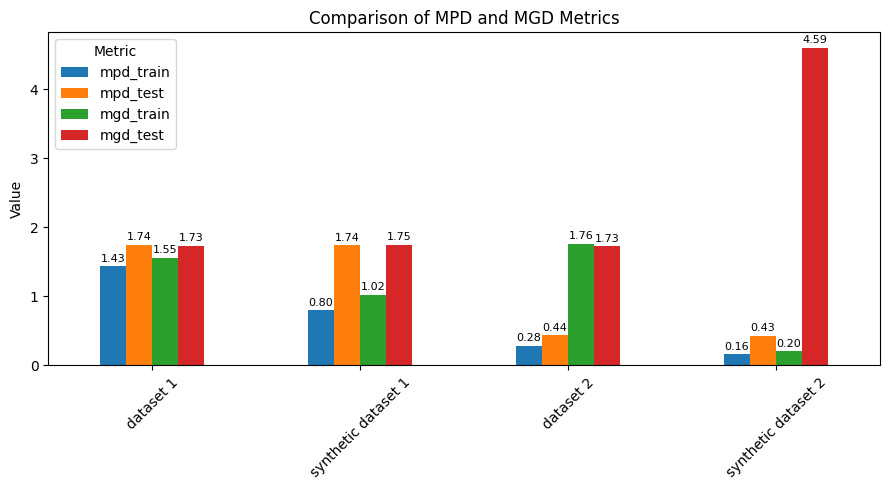

In [98]:
# Set up the plot
ax = df_tot.plot(kind='bar', figsize=(9, 5))

# Labels and title
plt.title('Comparison of MPD and MGD Metrics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')

# Add value labels with smaller font size
for container in ax.containers:
    labels = ax.bar_label(container, fmt='%.2f', label_type='edge', padding=2)
    for label in labels:
        label.set_fontsize(8)

plt.tight_layout()
plt.show()

